In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import glob
import warnings
import copy

warnings.filterwarnings("ignore", "Could not infer format", UserWarning)

In [2]:
from codes.codes.csv_data_reader import csv_data_reader
from codes.codes.hyperspectral_data_reader import (
    open_datacube,
    convert_to_reflectance,
    crop_datacube,
    apply_combined_mask,
    calculate_mean_std_image
)

In [3]:
# --- Configuration and Constants ---
# --- Paths (modify if your structure is different) ---
DATA_ROOT = "." # Assuming the script is run from the root directory containing the data folders
HYPER_DIRS = [f"hyperspectral_acquisitions_part0{i+1}" for i in range(5)]
REF_DIR = os.path.join(DATA_ROOT, "data", "data", "1_reference_for_hyperspectral_acquisitions", "references")
LAB_DATA_PATH = os.path.join(DATA_ROOT, "data", "data", "5_laboratory_reference_measurements", "laboratory_measurements.csv")
PROCESSED_SPECTRA_CACHE = "processed_spectra.csv"
BEST_MODEL_PATH = "best_vit_model.pth"

# --- Model Hyperparameters ---
PATCH_SIZE = 10
NUM_PATCHES = 20 # 200 spectral bands / 10 patch size
MODEL_DIM = 128
NUM_HEADS = 8
NUM_LAYERS = 6
MLP_DIM = 256
DROPOUT_RATE = 0.15 # Regularization to make the model "smarter"

# *** UPDATED: New target classes as requested ***
TARGET_COLS = ['lab_doc_mg_l', 'lab_po4_mg_l', 'lab_so4_mg_l', 'lab_nh4_mg_l', 'lab_nsol_mg_l', 'lab_turbidity_ntu']
NUM_CLASSES = len(TARGET_COLS) # Now 6

# --- Training Hyperparameters ---
LEARNING_RATE = 1e-4
BATCH_SIZE = 16
NUM_EPOCHS = 100 # Increased epochs since early stopping will find the best one
EARLY_STOPPING_PATIENCE = 10 # Stop if validation loss doesn't improve for 10 epochs

# --- Set device ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
# --- 1. Data Loading and Preprocessing ---

def process_all_hyperspectral_data():
    """
    Processes all raw hyperspectral datacubes from the data folders,
    extracts the mean 1D spectrum, and saves the results to a CSV cache file.
    This is a long process and should only be run once.
    """
    print("Starting full hyperspectral data processing. This may take a very long time...")

    # Load reference files once
    try:
        whiteref = open_datacube(folder=REF_DIR, name="whiteReference")
        darkref = open_datacube(folder=REF_DIR, name="darkReference")
    except FileNotFoundError:
        print(f"Error: Reference files not found in {REF_DIR}. Please check paths.")
        return None

    all_spectra = []
    all_timestamps = []
    
    # Get all timestamped acquisition folders
    acquisition_folders = []
    for h_dir in HYPER_DIRS:
        path = os.path.join(DATA_ROOT, h_dir, "*")
        acquisition_folders.extend(glob.glob(path))

    print(f"Found {len(acquisition_folders)} hyperspectral acquisitions to process.")

    for folder in tqdm(acquisition_folders, desc="Processing Datacubes"):
        try:
            timestamp_str = os.path.basename(folder)
            timestamp = pd.to_datetime(timestamp_str, format='%Y-%m-%dT%H.%M.%S')

            # Full processing pipeline for one datacube
            datacube = open_datacube(folder=folder)
            datacube_norm = convert_to_reflectance(datacube, whiteref, darkref)
            datacube_crop = crop_datacube(datacube_norm)
            datacube_masked = apply_combined_mask(datacube_crop)
            mean_spectrum, _ = calculate_mean_std_image(datacube_masked)
            
            # Clip extreme values that might result from division by zero
            mean_spectrum = np.clip(mean_spectrum, -1e6, 1e6)
            
            all_spectra.append(mean_spectrum)
            all_timestamps.append(timestamp)

        except Exception as e:
            print(f"Skipping folder {folder} due to error: {e}")
            continue

    spectra_df = pd.DataFrame(all_spectra, index=all_timestamps)
    spectra_df.columns = [f"band_{i}" for i in range(spectra_df.shape[1])]
    spectra_df.to_csv(PROCESSED_SPECTRA_CACHE)
    print(f"Processing complete. Saved {len(spectra_df)} spectra to {PROCESSED_SPECTRA_CACHE}")
    return spectra_df


def load_and_merge_data():
    """
    Loads the cached processed spectra and the lab measurement data,
    then merges them based on the nearest timestamp.
    """
    if not os.path.exists(PROCESSED_SPECTRA_CACHE):
        print(f"Cache file '{PROCESSED_SPECTRA_CACHE}' not found.")
        spectra_df = process_all_hyperspectral_data()
        if spectra_df is None:
            return None
    else:
        print(f"Loading cached spectra from '{PROCESSED_SPECTRA_CACHE}'...")
        spectra_df = pd.read_csv(PROCESSED_SPECTRA_CACHE, index_col=0)
        spectra_df.index = pd.to_datetime(spectra_df.index)

    # Load lab data
    lab_df = csv_data_reader(LAB_DATA_PATH)
    lab_df = lab_df.set_index('timestamp_iso')
    
    # Define target columns and filter for samples with all required data
    target_cols = TARGET_COLS
    lab_df_filtered = lab_df[target_cols].dropna()
    print(f"Found {len(lab_df_filtered)} lab samples with complete data.")

    # Merge based on nearest timestamp
    spectra_df_sorted = spectra_df.sort_index()
    lab_df_sorted = lab_df_filtered.sort_index()

    merged_df = pd.merge_asof(left=lab_df_sorted,
                              right=spectra_df_sorted,
                              left_index=True,
                              right_index=True,
                              direction='nearest',
                              tolerance=pd.Timedelta('30 minutes'))
    
    final_df = merged_df.dropna()
    print(f"Successfully merged {len(final_df)} samples.")

    return final_df

In [5]:
# --- 2. PyTorch Dataset and Model Definitions ---

class SpectraDataset(Dataset):
    def __init__(self, dataframe, target_cols):
        self.spectra = dataframe.filter(regex='^band_').values
        self.targets = dataframe[target_cols].values

    def __len__(self):
        return len(self.spectra)

    def __getitem__(self, idx):
        spectrum = torch.tensor(self.spectra[idx], dtype=torch.float32)
        target = torch.tensor(self.targets[idx], dtype=torch.float32)
        return spectrum, target

class ViT1D(nn.Module):
    def __init__(self, num_patches, patch_size, model_dim, num_layers, num_heads, mlp_dim, num_classes, dropout_rate):
        super().__init__()
        self.patch_embedding = nn.Linear(patch_size, model_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, model_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, model_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dim_feedforward=mlp_dim, batch_first=True, dropout=dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(model_dim),
            nn.Linear(model_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout_rate), # Added dropout for regularization
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, x):
        x = x.unfold(dimension=1, size=PATCH_SIZE, step=PATCH_SIZE)
        x = self.patch_embedding(x)
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.transformer_encoder(x)
        cls_output = x[:, 0]
        output = self.mlp_head(cls_output)
        return output

class PhysicsInformedLoss(nn.Module):
    def __init__(self, lambda_weight, y_scaler):
        super().__init__()
        self.lambda_weight = lambda_weight
        self.y_scaler = y_scaler
        self.data_loss_fn = nn.MSELoss()

    def forward(self, y_pred_scaled, y_true_scaled):
        data_loss = self.data_loss_fn(y_pred_scaled, y_true_scaled)

        # Inverse transform predictions to original scale to check physics
        y_pred_unscaled = self.y_scaler.inverse_transform(y_pred_scaled.detach().cpu().numpy())
        y_pred_unscaled = torch.tensor(y_pred_unscaled, device=y_pred_scaled.device)
        
        toc_pred, doc_pred, tn_pred, tdn_pred = y_pred_unscaled.T

        loss_toc_doc = torch.mean(torch.relu(doc_pred - toc_pred))
        loss_tn_tdn = torch.mean(torch.relu(tdn_pred - tn_pred))
        loss_non_negative = torch.mean(torch.relu(-y_pred_unscaled))
        
        physics_loss = loss_toc_doc + loss_tn_tdn + loss_non_negative
        return data_loss + self.lambda_weight * physics_loss

In [6]:
def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs, patience, model_path):
    """
    NEW: Training loop with validation, early stopping, and best model saving.
    """
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_wts = None

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save the best model state
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, model_path)
            print(f"Validation loss improved. Saving model to {model_path}")
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
    
    # Load best model weights before returning
    print("Training finished. Loading best model weights for evaluation.")
    model.load_state_dict(torch.load(model_path))
    return model

def evaluate_model_detailed(model, dataloader, device, target_cols):
    """
    UPDATED: Now returns a DataFrame with sample predictions in addition to metrics.
    """
    model.eval()
    all_preds, all_trues = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            all_preds.append(y_pred.cpu().numpy())
            all_trues.append(y.cpu().numpy())
            
    all_preds = np.concatenate(all_preds)
    all_trues = np.concatenate(all_trues)
    
    # --- Calculate Metrics ---
    overall_rmse = np.sqrt(mean_squared_error(all_trues, all_preds))
    overall_mae = mean_absolute_error(all_trues, all_preds)
    results = {"Overall": {"RMSE": overall_rmse, "MAE": overall_mae}}
    for i, pollutant_name in enumerate(target_cols):
        class_rmse = np.sqrt(mean_squared_error(all_trues[:, i], all_preds[:, i]))
        class_mae = mean_absolute_error(all_trues[:, i], all_preds[:, i])
        results[pollutant_name] = {"RMSE": class_rmse, "MAE": class_mae}

    # --- NEW: Generate Sample Comparison DataFrame ---
    num_samples_to_show = min(5, len(all_trues)) # Show up to 5 samples
    sample_data = []
    for i in range(num_samples_to_show):
        for j, pollutant_name in enumerate(target_cols):
            sample_data.append({
                "Sample #": i + 1,
                "Pollutant": pollutant_name.replace("lab_", "").replace("_mg-l-1", "").replace("_fnu", ""),
                "Real Value": f"{all_trues[i, j]:.2f}",
                "Predicted Value": f"{all_preds[i, j]:.2f}"
            })
    samples_df = pd.DataFrame(sample_data)
        
    return results, samples_df

In [7]:
# --- 4. Main Execution Block ---
final_df = load_and_merge_data()

# Create dataset
dataset = SpectraDataset(final_df, TARGET_COLS)

Loading cached spectra from 'processed_spectra.csv'...
Found 505 lab samples with complete data.
Successfully merged 278 samples.


In [8]:
# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
print("\n--- Training 'Smarter' Vision Transformer with Early Stopping ---")
vit_model = ViT1D(
    num_patches=NUM_PATCHES, patch_size=PATCH_SIZE, model_dim=MODEL_DIM, 
    num_layers=NUM_LAYERS, num_heads=NUM_HEADS, mlp_dim=MLP_DIM, 
    num_classes=NUM_CLASSES, dropout_rate=DROPOUT_RATE
).to(DEVICE)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(vit_model.parameters(), lr=LEARNING_RATE)

# Run the robust training loop
trained_model = train_and_validate(
    model=vit_model, train_loader=train_loader, val_loader=val_loader,
    loss_fn=loss_fn, optimizer=optimizer, device=DEVICE,
    num_epochs=1000, patience=EARLY_STOPPING_PATIENCE, model_path=BEST_MODEL_PATH
)


--- Training 'Smarter' Vision Transformer with Early Stopping ---
Epoch 1/1000 | Train Loss: 6025.3016 | Val Loss: 5806.1201
Validation loss improved. Saving model to best_vit_model.pth
Epoch 2/1000 | Train Loss: 5905.1662 | Val Loss: 5726.5621
Validation loss improved. Saving model to best_vit_model.pth
Epoch 3/1000 | Train Loss: 5867.5795 | Val Loss: 5656.6766
Validation loss improved. Saving model to best_vit_model.pth
Epoch 4/1000 | Train Loss: 5790.1574 | Val Loss: 5577.8364
Validation loss improved. Saving model to best_vit_model.pth
Epoch 5/1000 | Train Loss: 5689.8982 | Val Loss: 5484.3245
Validation loss improved. Saving model to best_vit_model.pth
Epoch 6/1000 | Train Loss: 5603.7648 | Val Loss: 5375.4979
Validation loss improved. Saving model to best_vit_model.pth
Epoch 7/1000 | Train Loss: 5471.7321 | Val Loss: 5249.0253
Validation loss improved. Saving model to best_vit_model.pth
Epoch 8/1000 | Train Loss: 5347.5783 | Val Loss: 5106.9185
Validation loss improved. Saving m

In [10]:
print("\n--- Final Detailed Evaluation on Validation Set ---")
detailed_results, samples_df = evaluate_model_detailed(trained_model, val_loader, DEVICE, TARGET_COLS)

# Nicely print the results
print("\n" + "="*50)
print(" " * 15 + "DETAILED RESULTS")
print("="*50)
for key, metrics in detailed_results.items():
    print(f"\nTarget: {key}")
    print(f"  - RMSE: {metrics['RMSE']:.4f}")
    print(f"  - MAE:  {metrics['MAE']:.4f}")
print("="*50)


--- Final Detailed Evaluation on Validation Set ---

               DETAILED RESULTS

Target: Overall
  - RMSE: 25.3915
  - MAE:  14.3867

Target: lab_doc_mg_l
  - RMSE: 46.9914
  - MAE:  35.0694

Target: lab_po4_mg_l
  - RMSE: 1.0714
  - MAE:  0.8966

Target: lab_so4_mg_l
  - RMSE: 7.4187
  - MAE:  4.4747

Target: lab_nh4_mg_l
  - RMSE: 8.7749
  - MAE:  6.7083

Target: lab_nsol_mg_l
  - RMSE: 12.7965
  - MAE:  10.5075

Target: lab_turbidity_ntu
  - RMSE: 36.9220
  - MAE:  28.6636


In [11]:
("\n" + "="*50)
print(" " * 12 + "SAMPLE PREDICTIONS")
print("="*50)
print(samples_df.to_string(index=False))
print("="*50)

            SAMPLE PREDICTIONS
 Sample #     Pollutant Real Value Predicted Value
        1      doc_mg_l      82.10           94.62
        1      po4_mg_l       2.33            2.70
        1      so4_mg_l      39.80           35.18
        1      nh4_mg_l      27.30           27.16
        1     nsol_mg_l      36.70           39.39
        1 turbidity_ntu     143.00          139.95
        2      doc_mg_l     262.00           95.56
        2      po4_mg_l       2.55            2.74
        2      so4_mg_l      39.90           35.53
        2      nh4_mg_l      21.00           27.44
        2     nsol_mg_l      25.10           39.78
        2 turbidity_ntu     169.50          141.39
        3      doc_mg_l      92.00           97.58
        3      po4_mg_l       3.87            2.85
        3      so4_mg_l      36.30           36.29
        3      nh4_mg_l      40.70           28.02
        3     nsol_mg_l      53.80           40.63
        3 turbidity_ntu     168.50          144.56


In [6]:
# %%
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import glob
import warnings

warnings.filterwarnings("ignore", "Could not infer format", UserWarning)

# %%
# Note: The original data reader functions from your 'codes' directory are assumed to be available.
# If they are not in the expected path, you might need to adjust the import or copy the functions here.
from codes.codes.csv_data_reader import csv_data_reader
from codes.codes.hyperspectral_data_reader import (
    open_datacube,
    convert_to_reflectance,
    crop_datacube,
    apply_combined_mask,
    calculate_mean_std_image
)

# %%
# --- Configuration and Constants ---
# --- Paths (modify if your structure is different) ---
DATA_ROOT = "." # Assuming the script is run from the root directory containing the data folders
HYPER_DIRS = [f"hyperspectral_acquisitions_part0{i+1}" for i in range(5)]
REF_DIR = os.path.join(DATA_ROOT, "data", "data", "1_reference_for_hyperspectral_acquisitions", "references")
LAB_DATA_PATH = os.path.join(DATA_ROOT, "data", "data", "5_laboratory_reference_measurements", "laboratory_measurements.csv")
PROCESSED_SPECTRA_CACHE = "processed_spectra.csv"

# --- Model Hyperparameters ---
# For PLS, the most important hyperparameter is the number of components.
# This value should be tuned, often using cross-validation, to find the best model.
N_COMPONENTS = 25 # This is a key hyperparameter to tune for PLS

# --- Target Columns ---
TARGET_COLS = ['lab_doc_mg_l', 'lab_po4_mg_l', 'lab_so4_mg_l', 'lab_nh4_mg_l', 'lab_nsol_mg_l', 'lab_turbidity_ntu']

# %%
# --- 1. Data Loading and Preprocessing ---

def process_all_hyperspectral_data():
    """
    Processes all raw hyperspectral datacubes from the data folders,
    extracts the mean 1D spectrum, and saves the results to a CSV cache file.
    This is a long process and should only be run once.
    """
    print("Starting full hyperspectral data processing. This may take a very long time...")

    # Load reference files once
    try:
        whiteref = open_datacube(folder=REF_DIR, name="whiteReference")
        darkref = open_datacube(folder=REF_DIR, name="darkReference")
    except FileNotFoundError:
        print(f"Error: Reference files not found in {REF_DIR}. Please check paths.")
        return None

    all_spectra = []
    all_timestamps = []
    
    # Get all timestamped acquisition folders
    acquisition_folders = []
    for h_dir in HYPER_DIRS:
        path = os.path.join(DATA_ROOT, h_dir, "*")
        acquisition_folders.extend(glob.glob(path))

    print(f"Found {len(acquisition_folders)} hyperspectral acquisitions to process.")

    for folder in tqdm(acquisition_folders, desc="Processing Datacubes"):
        try:
            timestamp_str = os.path.basename(folder)
            timestamp = pd.to_datetime(timestamp_str, format='%Y-%m-%dT%H.%M.%S')

            # Full processing pipeline for one datacube
            datacube = open_datacube(folder=folder)
            datacube_norm = convert_to_reflectance(datacube, whiteref, darkref)
            datacube_crop = crop_datacube(datacube_norm)
            datacube_masked = apply_combined_mask(datacube_crop)
            mean_spectrum, _ = calculate_mean_std_image(datacube_masked)
            
            # Clip extreme values that might result from division by zero
            mean_spectrum = np.clip(mean_spectrum, -1e6, 1e6)
            
            all_spectra.append(mean_spectrum)
            all_timestamps.append(timestamp)

        except Exception as e:
            print(f"Skipping folder {folder} due to error: {e}")
            continue

    spectra_df = pd.DataFrame(all_spectra, index=all_timestamps)
    spectra_df.columns = [f"band_{i}" for i in range(spectra_df.shape[1])]
    spectra_df.to_csv(PROCESSED_SPECTRA_CACHE)
    print(f"Processing complete. Saved {len(spectra_df)} spectra to {PROCESSED_SPECTRA_CACHE}")
    return spectra_df


def load_and_merge_data():
    """
    Loads the cached processed spectra and the lab measurement data,
    then merges them based on the nearest timestamp.
    """
    if not os.path.exists(PROCESSED_SPECTRA_CACHE):
        print(f"Cache file '{PROCESSED_SPECTRA_CACHE}' not found.")
        spectra_df = process_all_hyperspectral_data()
        if spectra_df is None:
            return None
    else:
        print(f"Loading cached spectra from '{PROCESSED_SPECTRA_CACHE}'...")
        spectra_df = pd.read_csv(PROCESSED_SPECTRA_CACHE, index_col=0)
        spectra_df.index = pd.to_datetime(spectra_df.index)

    # Load lab data
    lab_df = csv_data_reader(LAB_DATA_PATH)
    lab_df = lab_df.set_index('timestamp_iso')
    
    # Define target columns and filter for samples with all required data
    lab_df_filtered = lab_df[TARGET_COLS].dropna()
    print(f"Found {len(lab_df_filtered)} lab samples with complete data.")

    # Merge based on nearest timestamp
    spectra_df_sorted = spectra_df.sort_index()
    lab_df_sorted = lab_df_filtered.sort_index()

    merged_df = pd.merge_asof(left=lab_df_sorted,
                              right=spectra_df_sorted,
                              left_index=True,
                              right_index=True,
                              direction='nearest',
                              tolerance=pd.Timedelta('30 minutes'))
    
    final_df = merged_df.dropna()
    print(f"Successfully merged {len(final_df)} samples.")

    return final_df

# %%
# --- 2. Evaluation Function ---

def evaluate_model_detailed(y_true, y_pred, target_cols):
    """
    Calculates detailed metrics and returns a DataFrame of sample predictions.
    """
    # --- Calculate Metrics ---
    overall_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    overall_mae = mean_absolute_error(y_true, y_pred)
    results = {"Overall": {"RMSE": overall_rmse, "MAE": overall_mae}}
    for i, pollutant_name in enumerate(target_cols):
        class_rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
        class_mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        results[pollutant_name] = {"RMSE": class_rmse, "MAE": class_mae}

    # --- Generate Sample Comparison DataFrame ---
    num_samples_to_show = min(5, len(y_true)) # Show up to 5 samples
    sample_data = []
    for i in range(num_samples_to_show):
        for j, pollutant_name in enumerate(target_cols):
            sample_data.append({
                "Sample #": i + 1,
                "Pollutant": pollutant_name.replace("lab_", "").replace("_mg_l", "").replace("_ntu", ""),
                "Real Value": f"{y_true[i, j]:.2f}",
                "Predicted Value": f"{y_pred[i, j]:.2f}"
            })
    samples_df = pd.DataFrame(sample_data)
        
    return results, samples_df


# %%
# --- 3. Main Execution Block ---
final_df = load_and_merge_data()

if final_df is not None and not final_df.empty:
    # Separate features (X) and targets (y)
    X = final_df.filter(regex='^band_').values
    y = final_df[TARGET_COLS].values

    # Split dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"\nData prepared for PLS Regression:")
    print(f"Training set size: {X_train.shape[0]}")
    print(f"Validation set size: {X_val.shape[0]}")

    # %%
    # --- 4. Model Training and Evaluation ---
    print(f"\n--- Training PLS Regression with {N_COMPONENTS} components ---")

    # Initialize and train the PLS model
    pls_model = PLSRegression(n_components=N_COMPONENTS)
    pls_model.fit(X_train, y_train)

    print("Training complete.")

    # Make predictions on the validation set
    y_pred = pls_model.predict(X_val)

    # %%
    print("\n--- Final Detailed Evaluation on Validation Set ---")
    detailed_results, samples_df = evaluate_model_detailed(y_val, y_pred, TARGET_COLS)

    # Nicely print the results
    print("\n" + "="*50)
    print(" " * 15 + "DETAILED RESULTS")
    print("="*50)
    for key, metrics in detailed_results.items():
        print(f"\nTarget: {key}")
        print(f"  - RMSE: {metrics['RMSE']:.4f}")
        print(f"  - MAE:  {metrics['MAE']:.4f}")
    print("="*50)

    # %%
    print("\n" + "="*50)
    print(" " * 12 + "SAMPLE PREDICTIONS")
    print("="*50)
    print(samples_df.to_string(index=False))
    print("="*50)

else:
    print("\nCould not load or process data. Exiting.")
# %%

Loading cached spectra from 'processed_spectra.csv'...
Found 505 lab samples with complete data.
Successfully merged 278 samples.

Data prepared for PLS Regression:
Training set size: 222
Validation set size: 56

--- Training PLS Regression with 25 components ---
Training complete.

--- Final Detailed Evaluation on Validation Set ---

               DETAILED RESULTS

Target: Overall
  - RMSE: 25.4375
  - MAE:  12.9969

Target: lab_doc_mg_l
  - RMSE: 54.2318
  - MAE:  43.7534

Target: lab_po4_mg_l
  - RMSE: 0.8202
  - MAE:  0.6082

Target: lab_so4_mg_l
  - RMSE: 6.6055
  - MAE:  4.9511

Target: lab_nh4_mg_l
  - RMSE: 6.1387
  - MAE:  4.8932

Target: lab_nsol_mg_l
  - RMSE: 7.9333
  - MAE:  6.6458

Target: lab_turbidity_ntu
  - RMSE: 28.2201
  - MAE:  17.1300

            SAMPLE PREDICTIONS
 Sample # Pollutant Real Value Predicted Value
        1       doc     114.00           60.52
        1       po4       1.04            2.69
        1       so4      32.50           35.05
        1   

In [7]:
# %%
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import glob
import warnings
import copy

from models import TimerBackbone

warnings.filterwarnings("ignore", "Could not infer format", UserWarning)

# %%
# --- Configuration and Constants ---
# --- Paths ---
DATA_ROOT = "."
HYPER_DIRS = [f"hyperspectral_acquisitions_part0{i+1}" for i in range(5)]
REF_DIR = os.path.join(DATA_ROOT, "data", "data", "1_reference_for_hyperspectral_acquisitions", "references")
LAB_DATA_PATH = os.path.join(DATA_ROOT, "data", "data", "5_laboratory_reference_measurements", "laboratory_measurements.csv")
PROCESSED_SPECTRA_CACHE = "processed_spectra.csv"
BEST_MODEL_PATH = "best_rwkv_model_ultimate.pth" # New path for our biggest model

# --- RWKV Model Configuration (INSPIRED BY YOUR CONFIG) ---
MODEL_CONFIG = {
    "task_name": "regression",
    "c_in": 1,
    "seq_len": 200,          # Will be updated automatically based on data
    "patch_len": 100,         # <--- YOUR VALUE
    "stride": 100,            # <--- YOUR VALUE
    "d_model": 256,          # <--- YOUR VALUE
    "n_layers": 8,          # <--- Inspired by your deep e_layers
    "e_layers": 8,
    "n_heads": 8,
    "enc_in": 1,
    "d_ff": 1024,            # <--- YOUR VALUE
    "dropout": 0.4,          # <--- High dropout for a large model
    "output_attention": False
}

# --- Target Columns ---
TARGET_COLS = ['lab_doc_mg_l', 'lab_po4_mg_l', 'lab_so4_mg_l', 'lab_nh4_mg_l', 'lab_nsol_mg_l', 'lab_turbidity_ntu']
NUM_CLASSES = len(TARGET_COLS)
MODEL_CONFIG['c_out'] = NUM_CLASSES

# --- Training Hyperparameters ---
LEARNING_RATE = 5e-5       # A smaller LR is often safer for large models
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 16            # Keeping batch size manageable
NUM_EPOCHS = 300           # Allow it to train for longer if needed
EARLY_STOPPING_PATIENCE = 25 # Be more patient with a large model

# --- Set device ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# %%
# --- Data Loading and Model Definitions (These sections are unchanged) ---

def process_all_hyperspectral_data():
    # ... (code is identical to previous version) ...
    print("Starting full hyperspectral data processing...")
    try:
        whiteref = open_datacube(folder=REF_DIR, name="whiteReference")
        darkref = open_datacube(folder=REF_DIR, name="darkReference")
    except FileNotFoundError: return None
    all_spectra, all_timestamps = [], []
    acquisition_folders = []
    for h_dir in HYPER_DIRS:
        acquisition_folders.extend(glob.glob(os.path.join(DATA_ROOT, h_dir, "*")))
    for folder in tqdm(acquisition_folders, desc="Processing Datacubes"):
        try:
            timestamp = pd.to_datetime(os.path.basename(folder), format='%Y-%m-%dT%H.%M.%S')
            datacube = open_datacube(folder=folder)
            datacube_norm = convert_to_reflectance(datacube, whiteref, darkref)
            datacube_crop = crop_datacube(datacube_norm)
            datacube_masked = apply_combined_mask(datacube_crop)
            mean_spectrum, _ = calculate_mean_std_image(datacube_masked)
            all_spectra.append(np.clip(mean_spectrum, -1e6, 1e6))
            all_timestamps.append(timestamp)
        except Exception: continue
    spectra_df = pd.DataFrame(all_spectra, index=all_timestamps)
    spectra_df.columns = [f"band_{i}" for i in range(spectra_df.shape[1])]
    spectra_df.to_csv(PROCESSED_SPECTRA_CACHE)
    return spectra_df


def load_and_merge_data():
    # ... (code is identical to previous version) ...
    if not os.path.exists(PROCESSED_SPECTRA_CACHE):
        spectra_df = process_all_hyperspectral_data()
        if spectra_df is None: return None
    else:
        print(f"Loading cached spectra from '{PROCESSED_SPECTRA_CACHE}'...")
        spectra_df = pd.read_csv(PROCESSED_SPECTRA_CACHE, index_col=0, parse_dates=True)
    lab_df = pd.read_csv(LAB_DATA_PATH, index_col='timestamp_iso', parse_dates=True)
    lab_df_filtered = lab_df[TARGET_COLS].dropna()
    merged_df = pd.merge_asof(lab_df_filtered.sort_index(),
                              spectra_df.sort_index(),
                              left_index=True, right_index=True,
                              direction='nearest', tolerance=pd.Timedelta('30 minutes'))
    final_df = merged_df.dropna()
    print(f"Successfully merged {len(final_df)} samples.")
    return final_df


class SpectraDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32).unsqueeze(1)
        self.targets = torch.tensor(targets, dtype=torch.float32)
    def __len__(self): return len(self.features)
    def __getitem__(self, idx): return self.features[idx], self.targets[idx]

class RWKVRegressionModel(nn.Module):
    def __init__(self, configs):
        super().__init__()
        class Configs:
            def __init__(self, config_dict):
                for key, value in config_dict.items():
                    setattr(self, key, value)
        configs_obj = Configs(configs)
        self.task_name = configs_obj.task_name
        self.backbone = TimerBackbone.Model_RWKV7(configs_obj)
        self.regression_head = nn.Sequential(nn.AdaptiveAvgPool1d(1), nn.Flatten(), nn.Linear(configs_obj.d_model, configs_obj.c_out))
    def regression(self, x_enc):
        B, M, L = x_enc.shape
        means = x_enc.mean(2, keepdim=True).detach()
        x_enc = x_enc - means
        stdev = torch.sqrt(torch.var(x_enc, dim=2, keepdim=True, unbiased=False) + 1e-5).detach()
        x_enc /= stdev
        enc_out, n_vars = self.backbone.patch_embedding(x_enc)
        enc_out, attns = self.backbone.decoder(enc_out)
        output = enc_out.reshape(B, M, -1, self.backbone.d_model)
        output = output.mean(dim=1).permute(0, 2, 1)
        output = self.regression_head(output)
        return output
    def forward(self, x_enc, **kwargs):
        if self.task_name == 'regression': return self.regression(x_enc)
        raise NotImplementedError

# %%
# --- 3. Training and Evaluation Functions (Unchanged from previous successful run) ---

def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, scheduler, device, num_epochs, patience, model_path):
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        current_lr = optimizer.param_groups[0]['lr']
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (LR: {current_lr:.1E})')
        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                val_loss += loss_fn(y_pred, y).item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)
        print(f"Epoch {epoch+1} Summary | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
            print(f"Validation loss improved. Saving model to {model_path}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {patience} epochs with no improvement.")
                break
    
    print("Training finished. Loading best model for evaluation.")
    model.load_state_dict(torch.load(model_path))
    return model

def evaluate_model_detailed(model, dataloader, device, target_cols, x_scaler, y_scaler):
    model.eval()
    all_preds_scaled, all_trues_scaled = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y_pred_scaled = model(X)
            all_preds_scaled.append(y_pred_scaled.cpu().numpy())
            all_trues_scaled.append(y.cpu().numpy())
    all_preds_scaled = np.concatenate(all_preds_scaled)
    all_trues_scaled = np.concatenate(all_trues_scaled)
    all_preds = y_scaler.inverse_transform(all_preds_scaled)
    all_trues = y_scaler.inverse_transform(all_trues_scaled)
    results = {"Overall": {"RMSE": np.sqrt(mean_squared_error(all_trues, all_preds)), "MAE": mean_absolute_error(all_trues, all_preds)}}
    for i, name in enumerate(target_cols):
        results[name] = {"RMSE": np.sqrt(mean_squared_error(all_trues[:, i], all_preds[:, i])), "MAE": mean_absolute_error(all_trues[:, i], all_preds[:, i])}
    sample_data = []
    for i in range(min(5, len(all_trues))):
        for j, name in enumerate(target_cols):
            sample_data.append({"Sample #": i + 1, "Pollutant": name, "Real Value": f"{all_trues[i, j]:.2f}", "Predicted Value": f"{all_preds[i, j]:.2f}"})
    return results, pd.DataFrame(sample_data)

# %%
# --- 4. Main Execution Block ---
final_df = load_and_merge_data()

if final_df is not None:
    X = final_df.filter(regex='^band_').values
    y = final_df[TARGET_COLS].values
    
    # Check if the number of bands is divisible by the patch length
    if X.shape[1] % MODEL_CONFIG['patch_len'] != 0:
        raise ValueError(f"Sequence length ({X.shape[1]}) must be divisible by patch_len ({MODEL_CONFIG['patch_len']}).")
    MODEL_CONFIG['seq_len'] = X.shape[1]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print("\n--- Scaling features (X) and targets (y) ---")
    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_train_scaled = x_scaler.fit_transform(X_train)
    y_train_scaled = y_scaler.fit_transform(y_train)
    X_val_scaled = x_scaler.transform(X_val)
    y_val_scaled = y_scaler.transform(y_val)
    print("Scaling complete.")

    train_dataset = SpectraDataset(X_train_scaled, y_train_scaled)
    val_dataset = SpectraDataset(X_val_scaled, y_val_scaled)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print("\n--- Training 'Ultimate' RWKV Model with LR Scheduler ---")
    rwkv_model = RWKVRegressionModel(MODEL_CONFIG).to(DEVICE)
    loss_fn = nn.MSELoss()
    optimizer = optim.AdamW(rwkv_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=7)

    trained_model = train_and_validate(
        model=rwkv_model, train_loader=train_loader, val_loader=val_loader,
        loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler,
        device=DEVICE, num_epochs=NUM_EPOCHS, 
        patience=EARLY_STOPPING_PATIENCE, model_path=BEST_MODEL_PATH
    )

    print("\n--- Final Detailed Evaluation on Validation Set ---")
    detailed_results, samples_df = evaluate_model_detailed(
        trained_model, val_loader, DEVICE, TARGET_COLS, x_scaler, y_scaler
    )

    print("\n" + "="*50 + "\n" + " " * 15 + "DETAILED RESULTS\n" + "="*50)
    for key, metrics in detailed_results.items():
        print(f"\nTarget: {key}\n  - RMSE: {metrics['RMSE']:.4f}\n  - MAE:  {metrics['MAE']:.4f}")
    print("="*50)

    print("\n" + "="*50 + "\n" + " " * 12 + "SAMPLE PREDICTIONS\n" + "="*50)
    print(samples_df.to_string(index=False))
    print("="*50)

Using device: cuda
Loading cached spectra from 'processed_spectra.csv'...
Successfully merged 278 samples.

--- Scaling features (X) and targets (y) ---
Scaling complete.

--- Training 'Ultimate' RWKV Model with LR Scheduler ---


Epoch 1/300 (LR: 5.0E-05):   0%|                                                                                                                              | 0/14 [00:00<?, ?it/s]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/rwkvfla/ops/rwkv7/chunk.py:66: UserWarning: Input tensor shape suggests potential format mismatch: seq_len (2) < num_heads (4). This may indicate the inputs were passed in head-first format [B, H, T, ...] when head_first=False was specified. Please verify your input tensor format matches the expected shape [B, T, H, ...].
  warnings.warn(
/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/rwkvfla/ops/generalized_delta_rule/dplr/chunk.py:325: UserWarning: Input tensor shape suggests potential format mismatch: seq_len (2) < num_heads (4). This may indicate the inputs were passed in head-first format [B, H, T, ...] when head_first=False was specified. Please verify your input tensor format matches the expected shape [B, T, H, ...].
  warning

Epoch 1 Summary | Train Loss: 1.2947 | Val Loss: 1.0444
Validation loss improved. Saving model to best_rwkv_model_ultimate.pth


Epoch 2/300 (LR: 5.0E-05):   0%|                                                                                                                              | 0/14 [00:00<?, ?it/s]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/rwkvfla/ops/rwkv7/chunk.py:66: UserWarning: Input tensor shape suggests potential format mismatch: seq_len (2) < num_heads (4). This may indicate the inputs were passed in head-first format [B, H, T, ...] when head_first=False was specified. Please verify your input tensor format matches the expected shape [B, T, H, ...].
  warnings.warn(
/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/rwkvfla/ops/generalized_delta_rule/dplr/chunk.py:325: UserWarning: Input tensor shape suggests potential format mismatch: seq_len (2) < num_heads (4). This may indicate the inputs were passed in head-first format [B, H, T, ...] when head_first=False was specified. Please verify your input tensor format matches the expected shape [B, T, H, ...].
  warning

Epoch 2 Summary | Train Loss: 1.1276 | Val Loss: 0.9284
Validation loss improved. Saving model to best_rwkv_model_ultimate.pth


Epoch 3/300 (LR: 5.0E-05): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 42.70it/s, loss=0.7496]


Epoch 3 Summary | Train Loss: 1.0803 | Val Loss: 0.8986
Validation loss improved. Saving model to best_rwkv_model_ultimate.pth


Epoch 4/300 (LR: 5.0E-05): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 45.64it/s, loss=0.8215]


Epoch 4 Summary | Train Loss: 1.0253 | Val Loss: 0.8858
Validation loss improved. Saving model to best_rwkv_model_ultimate.pth


Epoch 5/300 (LR: 5.0E-05): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 46.59it/s, loss=1.0166]


Epoch 5 Summary | Train Loss: 0.9960 | Val Loss: 0.8717
Validation loss improved. Saving model to best_rwkv_model_ultimate.pth


Epoch 6/300 (LR: 5.0E-05): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 45.39it/s, loss=1.6521]


Epoch 6 Summary | Train Loss: 0.9787 | Val Loss: 0.8612
Validation loss improved. Saving model to best_rwkv_model_ultimate.pth


Epoch 7/300 (LR: 5.0E-05): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 40.54it/s, loss=1.1041]


Epoch 7 Summary | Train Loss: 0.9615 | Val Loss: 0.8599
Validation loss improved. Saving model to best_rwkv_model_ultimate.pth


Epoch 8/300 (LR: 5.0E-05): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 41.31it/s, loss=1.5946]


Epoch 8 Summary | Train Loss: 0.9671 | Val Loss: 0.8448
Validation loss improved. Saving model to best_rwkv_model_ultimate.pth


Epoch 9/300 (LR: 5.0E-05): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 49.03it/s, loss=1.0126]


Epoch 9 Summary | Train Loss: 0.9514 | Val Loss: 0.8334
Validation loss improved. Saving model to best_rwkv_model_ultimate.pth


Epoch 10/300 (LR: 5.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 42.73it/s, loss=0.6027]


Epoch 10 Summary | Train Loss: 0.9640 | Val Loss: 0.8281
Validation loss improved. Saving model to best_rwkv_model_ultimate.pth


Epoch 11/300 (LR: 5.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 41.25it/s, loss=1.2345]


Epoch 11 Summary | Train Loss: 0.9540 | Val Loss: 0.8293


Epoch 12/300 (LR: 5.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 46.96it/s, loss=0.9311]


Epoch 12 Summary | Train Loss: 0.9462 | Val Loss: 0.8230
Validation loss improved. Saving model to best_rwkv_model_ultimate.pth


Epoch 13/300 (LR: 5.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 39.64it/s, loss=0.5774]


Epoch 13 Summary | Train Loss: 0.8907 | Val Loss: 0.8235


Epoch 14/300 (LR: 5.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 48.57it/s, loss=0.7305]


Epoch 14 Summary | Train Loss: 0.9275 | Val Loss: 0.8187
Validation loss improved. Saving model to best_rwkv_model_ultimate.pth


Epoch 15/300 (LR: 5.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 49.37it/s, loss=0.9959]


Epoch 15 Summary | Train Loss: 0.9015 | Val Loss: 0.8185
Validation loss improved. Saving model to best_rwkv_model_ultimate.pth


Epoch 16/300 (LR: 5.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 44.01it/s, loss=0.6467]


Epoch 16 Summary | Train Loss: 0.8896 | Val Loss: 0.8127
Validation loss improved. Saving model to best_rwkv_model_ultimate.pth


Epoch 17/300 (LR: 5.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 44.54it/s, loss=1.0410]


Epoch 17 Summary | Train Loss: 0.8735 | Val Loss: 0.8105
Validation loss improved. Saving model to best_rwkv_model_ultimate.pth


Epoch 18/300 (LR: 5.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 47.93it/s, loss=0.6568]


Epoch 18 Summary | Train Loss: 0.8739 | Val Loss: 0.8183


Epoch 19/300 (LR: 5.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 46.14it/s, loss=1.2278]


Epoch 19 Summary | Train Loss: 0.8897 | Val Loss: 0.8037
Validation loss improved. Saving model to best_rwkv_model_ultimate.pth


Epoch 20/300 (LR: 5.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 42.99it/s, loss=0.8875]


Epoch 20 Summary | Train Loss: 0.8511 | Val Loss: 0.7911
Validation loss improved. Saving model to best_rwkv_model_ultimate.pth


Epoch 21/300 (LR: 5.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 49.78it/s, loss=0.8503]


Epoch 21 Summary | Train Loss: 0.8685 | Val Loss: 0.7932


Epoch 22/300 (LR: 5.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 39.05it/s, loss=0.6672]


Epoch 22 Summary | Train Loss: 0.8543 | Val Loss: 0.7842
Validation loss improved. Saving model to best_rwkv_model_ultimate.pth


Epoch 23/300 (LR: 5.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 37.09it/s, loss=0.7845]


Epoch 23 Summary | Train Loss: 0.8300 | Val Loss: 0.7757
Validation loss improved. Saving model to best_rwkv_model_ultimate.pth


Epoch 24/300 (LR: 5.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 46.40it/s, loss=0.9004]


Epoch 24 Summary | Train Loss: 0.8459 | Val Loss: 0.7835


Epoch 25/300 (LR: 5.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 44.60it/s, loss=0.8319]


Epoch 25 Summary | Train Loss: 0.7866 | Val Loss: 0.8023


Epoch 26/300 (LR: 5.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 40.76it/s, loss=0.4465]


Epoch 26 Summary | Train Loss: 0.8000 | Val Loss: 0.8107


Epoch 27/300 (LR: 5.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 46.41it/s, loss=0.9068]


Epoch 27 Summary | Train Loss: 0.7945 | Val Loss: 0.7939


Epoch 28/300 (LR: 5.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 48.69it/s, loss=0.6373]


Epoch 28 Summary | Train Loss: 0.8265 | Val Loss: 0.7810


Epoch 29/300 (LR: 5.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 40.28it/s, loss=0.6664]


Epoch 29 Summary | Train Loss: 0.8119 | Val Loss: 0.7938


Epoch 30/300 (LR: 5.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 47.45it/s, loss=0.4341]


Epoch 30 Summary | Train Loss: 0.7651 | Val Loss: 0.8016


Epoch 31/300 (LR: 5.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 43.93it/s, loss=0.8652]


Epoch 31 Summary | Train Loss: 0.7830 | Val Loss: 0.7988


Epoch 32/300 (LR: 1.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 35.92it/s, loss=0.9032]


Epoch 32 Summary | Train Loss: 0.7847 | Val Loss: 0.8032


Epoch 33/300 (LR: 1.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 44.74it/s, loss=0.7907]


Epoch 33 Summary | Train Loss: 0.7783 | Val Loss: 0.7995


Epoch 34/300 (LR: 1.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 40.56it/s, loss=0.8493]


Epoch 34 Summary | Train Loss: 0.7935 | Val Loss: 0.7933


Epoch 35/300 (LR: 1.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 44.18it/s, loss=0.6288]


Epoch 35 Summary | Train Loss: 0.7805 | Val Loss: 0.7859


Epoch 36/300 (LR: 1.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 38.31it/s, loss=0.6504]


Epoch 36 Summary | Train Loss: 0.7742 | Val Loss: 0.7866


Epoch 37/300 (LR: 1.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 41.29it/s, loss=0.6058]


Epoch 37 Summary | Train Loss: 0.7807 | Val Loss: 0.7936


Epoch 38/300 (LR: 1.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 48.67it/s, loss=0.4862]


Epoch 38 Summary | Train Loss: 0.7747 | Val Loss: 0.7891


Epoch 39/300 (LR: 1.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 42.73it/s, loss=0.5812]


Epoch 39 Summary | Train Loss: 0.7615 | Val Loss: 0.7865


Epoch 40/300 (LR: 2.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 50.89it/s, loss=0.4733]


Epoch 40 Summary | Train Loss: 0.7352 | Val Loss: 0.7852


Epoch 41/300 (LR: 2.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 41.80it/s, loss=0.8586]


Epoch 41 Summary | Train Loss: 0.7760 | Val Loss: 0.7843


Epoch 42/300 (LR: 2.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 46.02it/s, loss=0.6434]


Epoch 42 Summary | Train Loss: 0.7664 | Val Loss: 0.7836


Epoch 43/300 (LR: 2.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 46.47it/s, loss=0.5266]


Epoch 43 Summary | Train Loss: 0.7927 | Val Loss: 0.7829


Epoch 44/300 (LR: 2.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 50.46it/s, loss=0.7217]


Epoch 44 Summary | Train Loss: 0.7808 | Val Loss: 0.7814


Epoch 45/300 (LR: 2.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 49.12it/s, loss=0.8649]


Epoch 45 Summary | Train Loss: 0.7458 | Val Loss: 0.7811


Epoch 46/300 (LR: 2.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 35.25it/s, loss=0.5064]


Epoch 46 Summary | Train Loss: 0.7501 | Val Loss: 0.7812


Epoch 47/300 (LR: 2.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 48.55it/s, loss=0.9976]


Epoch 47 Summary | Train Loss: 0.7434 | Val Loss: 0.7805


Epoch 48/300 (LR: 4.0E-07): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 43.56it/s, loss=0.6208]


Epoch 48 Summary | Train Loss: 0.7585 | Val Loss: 0.7804
Early stopping triggered after 25 epochs with no improvement.
Training finished. Loading best model for evaluation.

--- Final Detailed Evaluation on Validation Set ---

               DETAILED RESULTS

Target: Overall
  - RMSE: 28.3780
  - MAE:  15.0370

Target: lab_doc_mg_l
  - RMSE: 52.8056
  - MAE:  40.1329

Target: lab_po4_mg_l
  - RMSE: 0.8192
  - MAE:  0.6556

Target: lab_so4_mg_l
  - RMSE: 6.4015
  - MAE:  4.3421

Target: lab_nh4_mg_l
  - RMSE: 7.6202
  - MAE:  6.0256

Target: lab_nsol_mg_l
  - RMSE: 9.3914
  - MAE:  7.3720

Target: lab_turbidity_ntu
  - RMSE: 43.0757
  - MAE:  31.6937

            SAMPLE PREDICTIONS
 Sample #         Pollutant Real Value Predicted Value
        1      lab_doc_mg_l     114.00           71.72
        1      lab_po4_mg_l       1.04            2.89
        1      lab_so4_mg_l      32.50           32.53
        1      lab_nh4_mg_l      22.80           26.04
        1     lab_nsol_mg_l      36

In [ ]:
# %%
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import glob
import warnings

warnings.filterwarnings("ignore", "Could not infer format", UserWarning)

# %%
# --- Configuration and Constants ---
# --- Paths ---
DATA_ROOT = "."
HYPER_DIRS = [f"hyperspectral_acquisitions_part0{i+1}" for i in range(5)]
REF_DIR = os.path.join(DATA_ROOT, "data", "data", "1_reference_for_hyperspectral_acquisitions", "references")
LAB_DATA_PATH = os.path.join(DATA_ROOT, "data", "data", "5_laboratory_reference_measurements", "laboratory_measurements.csv")
PROCESSED_SPECTRA_CACHE = "processed_spectra.csv"
BEST_MODEL_PATH = "best_hybrid_cnn_transformer_model.pth"

# --- Transformer Backend Configuration ---
MODEL_CONFIG = {
    "d_model": 256,          # We can likely use a smaller model now that the CNN does the heavy lifting
    "n_layers": 8,
    "n_heads": 8,            # Standard transformer heads
    "d_ff": 1024,
    "dropout": 0.3
}

# --- Target Columns ---
TARGET_COLS = ['lab_doc_mg_l', 'lab_po4_mg_l', 'lab_so4_mg_l', 'lab_nh4_mg_l', 'lab_nsol_mg_l', 'lab_turbidity_ntu']
NUM_CLASSES = len(TARGET_COLS)
MODEL_CONFIG['c_out'] = NUM_CLASSES

# --- Training Hyperparameters ---
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 16
NUM_EPOCHS = 300
EARLY_STOPPING_PATIENCE = 30

# --- Set device ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# %%
# --- Data Loading (Unchanged) ---
# ... (Functions process_all_hyperspectral_data and load_and_merge_data are the same)
def process_all_hyperspectral_data():
    print("Starting full hyperspectral data processing...")
    try:
        whiteref = open_datacube(folder=REF_DIR, name="whiteReference")
        darkref = open_datacube(folder=REF_DIR, name="darkReference")
    except FileNotFoundError: return None
    all_spectra, all_timestamps = [], []
    acquisition_folders = []
    for h_dir in HYPER_DIRS:
        acquisition_folders.extend(glob.glob(os.path.join(DATA_ROOT, h_dir, "*")))
    for folder in tqdm(acquisition_folders, desc="Processing Datacubes"):
        try:
            timestamp = pd.to_datetime(os.path.basename(folder), format='%Y-%m-%dT%H.%M.%S')
            datacube = open_datacube(folder=folder)
            datacube_norm = convert_to_reflectance(datacube, whiteref, darkref)
            datacube_crop = crop_datacube(datacube_norm)
            datacube_masked = apply_combined_mask(datacube_crop)
            mean_spectrum, _ = calculate_mean_std_image(datacube_masked)
            all_spectra.append(np.clip(mean_spectrum, -1e6, 1e6))
            all_timestamps.append(timestamp)
        except Exception: continue
    spectra_df = pd.DataFrame(all_spectra, index=all_timestamps)
    spectra_df.columns = [f"band_{i}" for i in range(spectra_df.shape[1])]
    spectra_df.to_csv(PROCESSED_SPECTRA_CACHE)
    return spectra_df


def load_and_merge_data():
    if not os.path.exists(PROCESSED_SPECTRA_CACHE):
        spectra_df = process_all_hyperspectral_data()
        if spectra_df is None: return None
    else:
        print(f"Loading cached spectra from '{PROCESSED_SPECTRA_CACHE}'...")
        spectra_df = pd.read_csv(PROCESSED_SPECTRA_CACHE, index_col=0, parse_dates=True)
    lab_df = pd.read_csv(LAB_DATA_PATH, index_col='timestamp_iso', parse_dates=True)
    lab_df_filtered = lab_df[TARGET_COLS].dropna()
    merged_df = pd.merge_asof(lab_df_filtered.sort_index(),
                              spectra_df.sort_index(),
                              left_index=True, right_index=True,
                              direction='nearest', tolerance=pd.Timedelta('30 minutes'))
    final_df = merged_df.dropna()
    print(f"Successfully merged {len(final_df)} samples.")
    return final_df

# %%
# --- NEW HYBRID MODEL ARCHITECTURE ---

class SpectraDataset(Dataset):
    def __init__(self, features, targets):
        # Add a channel dimension for the CNN: [Batch, Seq_Len] -> [Batch, 1, Seq_Len]
        self.features = torch.tensor(features, dtype=torch.float32).unsqueeze(1)
        self.targets = torch.tensor(targets, dtype=torch.float32)
    def __len__(self): return len(self.features)
    def __getitem__(self, idx): return self.features[idx], self.targets[idx]

class HybridModel(nn.Module):
    def __init__(self, seq_len, configs):
        super().__init__()
        
        # --- 1. CNN Feature Extractor Frontend ---
        self.cnn_extractor = nn.Sequential(
            # Input: [Batch, 1, 200]
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=2, stride=2), # Output: [Batch, 64, 100]
            
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=2, stride=2), # Output: [Batch, 128, 50]
            
            nn.Conv1d(in_channels=128, out_channels=configs['d_model'], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(configs['d_model']),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=2, stride=2) # Final Output: [Batch, d_model, 25]
        )
        
        # --- 2. Transformer Encoder Backend ---
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=configs['d_model'], 
            nhead=configs['n_heads'], 
            dim_feedforward=configs['d_ff'], 
            dropout=configs['dropout'], 
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=configs['n_layers'])
        
        # --- 3. Regression Head ---
        self.regression_head = nn.Sequential(
            nn.Linear(configs['d_model'], configs['d_model'] // 2),
            nn.GELU(),
            nn.Dropout(configs['dropout']),
            nn.Linear(configs['d_model'] // 2, configs['c_out'])
        )
        
        # We need a CLS token to aggregate the transformer output
        self.cls_token = nn.Parameter(torch.zeros(1, 1, configs['d_model']))

    def forward(self, x):
        # x shape: [Batch, 1, Seq_Len]
        
        # Pass through CNN extractor
        x = self.cnn_extractor(x) # -> [Batch, d_model, ~25]
        
        # Prepare for transformer
        x = x.permute(0, 2, 1) # -> [Batch, ~25, d_model]
        
        # Prepend the CLS token
        B = x.shape[0]
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1) # -> [Batch, ~26, d_model]
        
        # Pass through transformer
        x = self.transformer_encoder(x) # -> [Batch, ~26, d_model]
        
        # Get the output of the CLS token
        cls_output = x[:, 0] # -> [Batch, d_model]
        
        # Pass through regression head
        output = self.regression_head(cls_output)
        return output

# %%
# --- Training and Evaluation (Unchanged from previous successful runs) ---

def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, scheduler, device, num_epochs, patience, model_path):
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        current_lr = optimizer.param_groups[0]['lr']
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (LR: {current_lr:.1E})')
        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                val_loss += loss_fn(y_pred, y).item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)
        print(f"Epoch {epoch+1} Summary | Train Loss: {avg_train_loss:.4f} | Val Loss (MSE): {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
            print(f"Validation loss improved. Saving model to {model_path}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered.")
                break
    
    print("Training finished. Loading best model.")
    model.load_state_dict(torch.load(model_path))
    return model

def evaluate_model_detailed(model, dataloader, device, target_cols, y_scaler):
    model.eval()
    all_preds_scaled, all_trues_scaled = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred_scaled = model(X)
            all_preds_scaled.append(y_pred_scaled.cpu().numpy())
            all_trues_scaled.append(y.cpu().numpy())
    all_preds_scaled = np.concatenate(all_preds_scaled)
    all_trues_scaled = np.concatenate(all_trues_scaled)
    all_preds = y_scaler.inverse_transform(all_preds_scaled)
    all_trues = y_scaler.inverse_transform(all_trues_scaled)
    results = {"Overall": {"RMSE": np.sqrt(mean_squared_error(all_trues, all_preds)), "MAE": mean_absolute_error(all_trues, all_preds)}}
    for i, name in enumerate(target_cols):
        results[name] = {"RMSE": np.sqrt(mean_squared_error(all_trues[:, i], all_preds[:, i])), "MAE": mean_absolute_error(all_trues[:, i], all_preds[:, i])}
    sample_data = []
    for i in range(min(5, len(all_trues))):
        for j, name in enumerate(target_cols):
            sample_data.append({"Sample #": i + 1, "Pollutant": name, "Real Value": f"{all_trues[i, j]:.2f}", "Predicted Value": f"{all_preds[i, j]:.2f}"})
    return results, pd.DataFrame(sample_data)


# %%
# --- 4. Main Execution Block ---
final_df = load_and_merge_data()

if final_df is not None:
    X = final_df.filter(regex='^band_').values
    y = final_df[TARGET_COLS].values
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_train_scaled = x_scaler.fit_transform(X_train)
    y_train_scaled = y_scaler.fit_transform(y_train)
    X_val_scaled = x_scaler.transform(X_val)
    y_val_scaled = y_scaler.transform(y_val)

    train_dataset = SpectraDataset(X_train_scaled, y_train_scaled)
    val_dataset = SpectraDataset(X_val_scaled, y_val_scaled)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print("\n--- Training Hybrid CNN-Transformer Model ---")
    seq_len = X_train.shape[1]
    model = HybridModel(seq_len=seq_len, configs=MODEL_CONFIG).to(DEVICE)
    
    loss_fn = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=10)

    trained_model = train_and_validate(
        model, train_loader, val_loader, loss_fn, optimizer, scheduler,
        DEVICE, NUM_EPOCHS, EARLY_STOPPING_PATIENCE, BEST_MODEL_PATH
    )

    print("\n--- Final Detailed Evaluation on Validation Set ---")
    detailed_results, samples_df = evaluate_model_detailed(
        trained_model, val_loader, DEVICE, TARGET_COLS, y_scaler
    )

    print("\n" + "="*50 + "\n" + " " * 15 + "DETAILED RESULTS\n" + "="*50)
    for key, metrics in detailed_results.items():
        print(f"\nTarget: {key}\n  - RMSE: {metrics['RMSE']:.4f}\n  - MAE:  {metrics['MAE']:.4f}")
    print("="*50)

    print("\n" + "="*50 + "\n" + " " * 12 + "SAMPLE PREDICTIONS\n" + "="*50)
    print(samples_df.to_string(index=False))
    print("="*50)

Using device: cuda
Loading cached spectra from 'processed_spectra.csv'...
Successfully merged 278 samples.

--- Training Hybrid CNN-Transformer Model ---


Epoch 1/300 (LR: 1.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 11.63it/s, loss=1.4990]


Epoch 1 Summary | Train Loss: 1.0339 | Val Loss (MSE): 0.9226
Validation loss improved. Saving model to best_hybrid_cnn_transformer_model.pth


Epoch 2/300 (LR: 1.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.33it/s, loss=0.6519]


Epoch 2 Summary | Train Loss: 0.9702 | Val Loss (MSE): 0.9022
Validation loss improved. Saving model to best_hybrid_cnn_transformer_model.pth


Epoch 3/300 (LR: 1.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 19.19it/s, loss=1.0611]


Epoch 3 Summary | Train Loss: 0.9822 | Val Loss (MSE): 0.8912
Validation loss improved. Saving model to best_hybrid_cnn_transformer_model.pth


Epoch 4/300 (LR: 1.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.10it/s, loss=0.8821]


Epoch 4 Summary | Train Loss: 0.9591 | Val Loss (MSE): 0.8785
Validation loss improved. Saving model to best_hybrid_cnn_transformer_model.pth


Epoch 5/300 (LR: 1.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.36it/s, loss=0.7361]


Epoch 5 Summary | Train Loss: 0.9451 | Val Loss (MSE): 0.8396
Validation loss improved. Saving model to best_hybrid_cnn_transformer_model.pth


Epoch 6/300 (LR: 1.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 18.75it/s, loss=0.8341]


Epoch 6 Summary | Train Loss: 0.9598 | Val Loss (MSE): 0.8201
Validation loss improved. Saving model to best_hybrid_cnn_transformer_model.pth


Epoch 7/300 (LR: 1.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 24.29it/s, loss=0.7641]


Epoch 7 Summary | Train Loss: 0.9364 | Val Loss (MSE): 0.7936
Validation loss improved. Saving model to best_hybrid_cnn_transformer_model.pth


Epoch 8/300 (LR: 1.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.45it/s, loss=0.8327]


Epoch 8 Summary | Train Loss: 0.8827 | Val Loss (MSE): 0.7303
Validation loss improved. Saving model to best_hybrid_cnn_transformer_model.pth


Epoch 9/300 (LR: 1.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 19.47it/s, loss=0.9069]


Epoch 9 Summary | Train Loss: 0.8681 | Val Loss (MSE): 0.7238
Validation loss improved. Saving model to best_hybrid_cnn_transformer_model.pth


Epoch 10/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.91it/s, loss=0.7768]


Epoch 10 Summary | Train Loss: 0.8504 | Val Loss (MSE): 0.7144
Validation loss improved. Saving model to best_hybrid_cnn_transformer_model.pth


Epoch 11/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 19.69it/s, loss=0.7559]


Epoch 11 Summary | Train Loss: 0.8250 | Val Loss (MSE): 0.6970
Validation loss improved. Saving model to best_hybrid_cnn_transformer_model.pth


Epoch 12/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 19.80it/s, loss=0.9441]


Epoch 12 Summary | Train Loss: 0.8330 | Val Loss (MSE): 0.8352


Epoch 13/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.29it/s, loss=1.1380]


Epoch 13 Summary | Train Loss: 0.8668 | Val Loss (MSE): 0.7009


Epoch 14/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.97it/s, loss=0.8968]


Epoch 14 Summary | Train Loss: 0.8360 | Val Loss (MSE): 0.6836
Validation loss improved. Saving model to best_hybrid_cnn_transformer_model.pth


Epoch 15/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.31it/s, loss=0.6968]


Epoch 15 Summary | Train Loss: 0.8022 | Val Loss (MSE): 0.6702
Validation loss improved. Saving model to best_hybrid_cnn_transformer_model.pth


Epoch 16/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.60it/s, loss=1.0915]


Epoch 16 Summary | Train Loss: 0.7813 | Val Loss (MSE): 0.6871


Epoch 17/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.25it/s, loss=1.3201]


Epoch 17 Summary | Train Loss: 0.8157 | Val Loss (MSE): 0.7503


Epoch 18/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.13it/s, loss=0.9367]


Epoch 18 Summary | Train Loss: 0.8246 | Val Loss (MSE): 0.6900


Epoch 19/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.81it/s, loss=0.7502]


Epoch 19 Summary | Train Loss: 0.7861 | Val Loss (MSE): 0.6662
Validation loss improved. Saving model to best_hybrid_cnn_transformer_model.pth


Epoch 20/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.73it/s, loss=0.8675]


Epoch 20 Summary | Train Loss: 0.8224 | Val Loss (MSE): 0.6848


Epoch 21/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.11it/s, loss=0.7198]


Epoch 21 Summary | Train Loss: 0.8149 | Val Loss (MSE): 0.6945


Epoch 22/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.83it/s, loss=1.0175]


Epoch 22 Summary | Train Loss: 0.7796 | Val Loss (MSE): 0.6850


Epoch 23/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.66it/s, loss=0.4931]


Epoch 23 Summary | Train Loss: 0.7396 | Val Loss (MSE): 0.6919


Epoch 24/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 17.92it/s, loss=0.5771]


Epoch 24 Summary | Train Loss: 0.7809 | Val Loss (MSE): 0.7213


Epoch 25/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.32it/s, loss=0.8178]


Epoch 25 Summary | Train Loss: 0.7573 | Val Loss (MSE): 0.7124


Epoch 26/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 18.90it/s, loss=0.8664]


Epoch 26 Summary | Train Loss: 0.7449 | Val Loss (MSE): 0.7114


Epoch 27/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 18.59it/s, loss=0.5637]


Epoch 27 Summary | Train Loss: 0.7421 | Val Loss (MSE): 0.7851


Epoch 28/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.84it/s, loss=0.3999]


Epoch 28 Summary | Train Loss: 0.7295 | Val Loss (MSE): 0.6867


Epoch 29/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.54it/s, loss=0.8230]


Epoch 29 Summary | Train Loss: 0.7686 | Val Loss (MSE): 0.7338


Epoch 30/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 25.25it/s, loss=1.0418]


Epoch 30 Summary | Train Loss: 0.7951 | Val Loss (MSE): 0.6614
Validation loss improved. Saving model to best_hybrid_cnn_transformer_model.pth


Epoch 31/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.35it/s, loss=0.6070]


Epoch 31 Summary | Train Loss: 0.7493 | Val Loss (MSE): 0.6633


Epoch 32/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.34it/s, loss=1.0023]


Epoch 32 Summary | Train Loss: 0.7538 | Val Loss (MSE): 0.6731


Epoch 33/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 25.42it/s, loss=0.8457]


Epoch 33 Summary | Train Loss: 0.7160 | Val Loss (MSE): 0.7739


Epoch 34/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 24.39it/s, loss=0.6982]


Epoch 34 Summary | Train Loss: 0.7225 | Val Loss (MSE): 0.7140


Epoch 35/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.87it/s, loss=0.5687]


Epoch 35 Summary | Train Loss: 0.7084 | Val Loss (MSE): 0.7232


Epoch 36/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.75it/s, loss=0.9383]


Epoch 36 Summary | Train Loss: 0.7336 | Val Loss (MSE): 0.6816


Epoch 37/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 24.51it/s, loss=0.6099]


Epoch 37 Summary | Train Loss: 0.7301 | Val Loss (MSE): 0.7481


Epoch 38/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.74it/s, loss=1.1180]


Epoch 38 Summary | Train Loss: 0.7847 | Val Loss (MSE): 0.6867


Epoch 39/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.49it/s, loss=0.5076]


Epoch 39 Summary | Train Loss: 0.7026 | Val Loss (MSE): 0.6863


Epoch 40/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 19.71it/s, loss=0.9850]


Epoch 40 Summary | Train Loss: 0.7363 | Val Loss (MSE): 0.8257


Epoch 41/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.43it/s, loss=0.9880]


Epoch 41 Summary | Train Loss: 0.7249 | Val Loss (MSE): 0.6943


Epoch 42/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.19it/s, loss=0.7625]


Epoch 42 Summary | Train Loss: 0.6843 | Val Loss (MSE): 0.6874


Epoch 43/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 17.74it/s, loss=0.7618]


Epoch 43 Summary | Train Loss: 0.6594 | Val Loss (MSE): 0.7026


Epoch 44/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.71it/s, loss=0.6256]


Epoch 44 Summary | Train Loss: 0.6791 | Val Loss (MSE): 0.6984


Epoch 45/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.34it/s, loss=0.5595]


Epoch 45 Summary | Train Loss: 0.6573 | Val Loss (MSE): 0.6992


Epoch 46/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.17it/s, loss=0.8660]


Epoch 46 Summary | Train Loss: 0.6678 | Val Loss (MSE): 0.6905


Epoch 47/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.39it/s, loss=0.6886]


Epoch 47 Summary | Train Loss: 0.6501 | Val Loss (MSE): 0.6854


Epoch 48/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 19.40it/s, loss=0.2884]


Epoch 48 Summary | Train Loss: 0.6294 | Val Loss (MSE): 0.6952


Epoch 49/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.81it/s, loss=0.9241]


Epoch 49 Summary | Train Loss: 0.6490 | Val Loss (MSE): 0.7047


Epoch 50/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.54it/s, loss=0.3594]


Epoch 50 Summary | Train Loss: 0.6525 | Val Loss (MSE): 0.7035


Epoch 51/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.82it/s, loss=0.4031]


Epoch 51 Summary | Train Loss: 0.6287 | Val Loss (MSE): 0.6936


Epoch 52/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.09it/s, loss=0.7958]


Epoch 52 Summary | Train Loss: 0.6634 | Val Loss (MSE): 0.6915


Epoch 53/300 (LR: 4.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.20it/s, loss=1.0841]


Epoch 53 Summary | Train Loss: 0.6442 | Val Loss (MSE): 0.6856


Epoch 54/300 (LR: 4.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 19.79it/s, loss=0.5777]


Epoch 54 Summary | Train Loss: 0.6242 | Val Loss (MSE): 0.6895


Epoch 55/300 (LR: 4.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 18.60it/s, loss=1.0027]


Epoch 55 Summary | Train Loss: 0.6356 | Val Loss (MSE): 0.6937


Epoch 56/300 (LR: 4.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.88it/s, loss=0.6447]


Epoch 56 Summary | Train Loss: 0.6230 | Val Loss (MSE): 0.6901


Epoch 57/300 (LR: 4.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.73it/s, loss=0.7882]


Epoch 57 Summary | Train Loss: 0.6554 | Val Loss (MSE): 0.6873


Epoch 58/300 (LR: 4.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.95it/s, loss=0.4944]


Epoch 58 Summary | Train Loss: 0.6471 | Val Loss (MSE): 0.6896


Epoch 59/300 (LR: 4.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.39it/s, loss=0.6852]


Epoch 59 Summary | Train Loss: 0.6295 | Val Loss (MSE): 0.6894


Epoch 60/300 (LR: 4.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.23it/s, loss=0.9193]


Epoch 60 Summary | Train Loss: 0.6427 | Val Loss (MSE): 0.6862
Early stopping triggered.
Training finished. Loading best model.

--- Final Detailed Evaluation on Validation Set ---

               DETAILED RESULTS

Target: Overall
  - RMSE: 24.8011
  - MAE:  12.8331

Target: lab_doc_mg_l
  - RMSE: 46.2029
  - MAE:  34.6342

Target: lab_po4_mg_l
  - RMSE: 0.7088
  - MAE:  0.5298

Target: lab_so4_mg_l
  - RMSE: 6.3352
  - MAE:  3.9523

Target: lab_nh4_mg_l
  - RMSE: 7.0643
  - MAE:  5.2385

Target: lab_nsol_mg_l
  - RMSE: 9.5645
  - MAE:  6.8403

Target: lab_turbidity_ntu
  - RMSE: 37.0651
  - MAE:  25.8035

            SAMPLE PREDICTIONS
 Sample #         Pollutant Real Value Predicted Value
        1      lab_doc_mg_l     114.00           66.65
        1      lab_po4_mg_l       1.04            2.16
        1      lab_so4_mg_l      32.50           29.85
        1      lab_nh4_mg_l      22.80           20.91
        1     lab_nsol_mg_l      36.90           34.99
        1 lab_turbidity_n

In [9]:
# %%
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import glob
import warnings
import math

warnings.filterwarnings("ignore", "Could not infer format", UserWarning)

# %%
# --- Configuration and Constants ---
# --- Paths ---
DATA_ROOT = "."
HYPER_DIRS = [f"hyperspectral_acquisitions_part0{i+1}" for i in range(5)]
REF_DIR = os.path.join(DATA_ROOT, "data", "data", "1_reference_for_hyperspectral_acquisitions", "references")
LAB_DATA_PATH = os.path.join(DATA_ROOT, "data", "data", "5_laboratory_reference_measurements", "laboratory_measurements.csv")
PROCESSED_SPECTRA_CACHE = "processed_spectra.csv"
BEST_MODEL_PATH = "best_raw_transformer_model.pth"

# --- Transformer Configuration ---
MODEL_CONFIG = {
    "d_model": 256,
    "n_layers": 8,
    "n_heads": 8,
    "d_ff": 1024,
    "dropout": 0.3
}

# --- Target Columns ---
TARGET_COLS = ['lab_doc_mg_l', 'lab_po4_mg_l', 'lab_so4_mg_l', 'lab_nh4_mg_l', 'lab_nsol_mg_l', 'lab_turbidity_ntu']
NUM_CLASSES = len(TARGET_COLS)
MODEL_CONFIG['c_out'] = NUM_CLASSES

# --- Training Hyperparameters ---
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 16
NUM_EPOCHS = 300
EARLY_STOPPING_PATIENCE = 30

# --- Set device ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# %%
# --- Data Loading (Unchanged) ---
# ... (Functions process_all_hyperspectral_data and load_and_merge_data are the same)
def process_all_hyperspectral_data():
    print("Starting full hyperspectral data processing...")
    try:
        whiteref = open_datacube(folder=REF_DIR, name="whiteReference")
        darkref = open_datacube(folder=REF_DIR, name="darkReference")
    except FileNotFoundError: return None
    all_spectra, all_timestamps = [], []
    acquisition_folders = []
    for h_dir in HYPER_DIRS:
        acquisition_folders.extend(glob.glob(os.path.join(DATA_ROOT, h_dir, "*")))
    for folder in tqdm(acquisition_folders, desc="Processing Datacubes"):
        try:
            timestamp = pd.to_datetime(os.path.basename(folder), format='%Y-%m-%dT%H.%M.%S')
            datacube = open_datacube(folder=folder)
            datacube_norm = convert_to_reflectance(datacube, whiteref, darkref)
            datacube_crop = crop_datacube(datacube_norm)
            datacube_masked = apply_combined_mask(datacube_crop)
            mean_spectrum, _ = calculate_mean_std_image(datacube_masked)
            all_spectra.append(np.clip(mean_spectrum, -1e6, 1e6))
            all_timestamps.append(timestamp)
        except Exception: continue
    spectra_df = pd.DataFrame(all_spectra, index=all_timestamps)
    spectra_df.columns = [f"band_{i}" for i in range(spectra_df.shape[1])]
    spectra_df.to_csv(PROCESSED_SPECTRA_CACHE)
    return spectra_df


def load_and_merge_data():
    if not os.path.exists(PROCESSED_SPECTRA_CACHE):
        spectra_df = process_all_hyperspectral_data()
        if spectra_df is None: return None
    else:
        print(f"Loading cached spectra from '{PROCESSED_SPECTRA_CACHE}'...")
        spectra_df = pd.read_csv(PROCESSED_SPECTRA_CACHE, index_col=0, parse_dates=True)
    lab_df = pd.read_csv(LAB_DATA_PATH, index_col='timestamp_iso', parse_dates=True)
    lab_df_filtered = lab_df[TARGET_COLS].dropna()
    merged_df = pd.merge_asof(lab_df_filtered.sort_index(),
                              spectra_df.sort_index(),
                              left_index=True, right_index=True,
                              direction='nearest', tolerance=pd.Timedelta('30 minutes'))
    final_df = merged_df.dropna()
    print(f"Successfully merged {len(final_df)} samples.")
    return final_df

# %%
# --- NEW RAW TRANSFORMER MODEL ARCHITECTURE ---

class SpectraDataset(Dataset):
    def __init__(self, features, targets):
        # Features are now just [Batch, Seq_Len]. NO channel dimension needed.
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)
    def __len__(self): return len(self.features)
    def __getitem__(self, idx): return self.features[idx], self.targets[idx]

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x shape: [Batch, Seq_Len, d_model]
        return x + self.pe[:, :x.size(1)]

class RawTransformerModel(nn.Module):
    def __init__(self, seq_len, configs):
        super().__init__()
        
        # 1. Band-wise Embedding
        # We treat each band as a single value and project it to d_model
        self.embedding = nn.Linear(1, configs['d_model'])
        self.pos_encoder = PositionalEncoding(configs['d_model'], max_len=seq_len + 1)
        
        # 2. Transformer Encoder Backend
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=configs['d_model'], nhead=configs['n_heads'], 
            dim_feedforward=configs['d_ff'], dropout=configs['dropout'], batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=configs['n_layers'])
        
        # 3. Regression Head
        self.regression_head = nn.Sequential(
            nn.Linear(configs['d_model'], configs['d_model'] // 2), nn.GELU(),
            nn.Dropout(configs['dropout']),
            nn.Linear(configs['d_model'] // 2, configs['c_out'])
        )
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, configs['d_model']))

    def forward(self, x):
        # x shape: [Batch, Seq_Len]
        
        # Unsqueeze to add a dimension for each band's value: [Batch, Seq_Len, 1]
        x = x.unsqueeze(-1)
        
        # Pass through band-wise embedding
        x = self.embedding(x) # -> [Batch, Seq_Len, d_model]
        
        # Prepend the CLS token
        B = x.shape[0]
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1) # -> [Batch, Seq_Len+1, d_model]
        
        # Add positional encoding
        x = self.pos_encoder(x)
        
        # Pass through transformer
        x = self.transformer_encoder(x) # -> [Batch, Seq_Len+1, d_model]
        
        # Get the output of the CLS token
        cls_output = x[:, 0] # -> [Batch, d_model]
        
        # Pass through regression head
        output = self.regression_head(cls_output)
        return output

# %%
# --- Training and Evaluation (Unchanged) ---

def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, scheduler, device, num_epochs, patience, model_path):
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        current_lr = optimizer.param_groups[0]['lr']
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (LR: {current_lr:.1E})')
        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                val_loss += loss_fn(y_pred, y).item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)
        print(f"Epoch {epoch+1} Summary | Train Loss: {avg_train_loss:.4f} | Val Loss (MSE): {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
            print(f"Validation loss improved. Saving model to {model_path}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered.")
                break
    
    print("Training finished. Loading best model.")
    model.load_state_dict(torch.load(model_path))
    return model

def evaluate_model_detailed(model, dataloader, device, target_cols, y_scaler):
    model.eval()
    all_preds_scaled, all_trues_scaled = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred_scaled = model(X)
            all_preds_scaled.append(y_pred_scaled.cpu().numpy())
            all_trues_scaled.append(y.cpu().numpy())
    all_preds_scaled = np.concatenate(all_preds_scaled)
    all_trues_scaled = np.concatenate(all_trues_scaled)
    all_preds = y_scaler.inverse_transform(all_preds_scaled)
    all_trues = y_scaler.inverse_transform(all_trues_scaled)
    results = {"Overall": {"RMSE": np.sqrt(mean_squared_error(all_trues, all_preds)), "MAE": mean_absolute_error(all_trues, all_preds)}}
    for i, name in enumerate(target_cols):
        results[name] = {"RMSE": np.sqrt(mean_squared_error(all_trues[:, i], all_preds[:, i])), "MAE": mean_absolute_error(all_trues[:, i], all_preds[:, i])}
    sample_data = []
    for i in range(min(5, len(all_trues))):
        for j, name in enumerate(target_cols):
            sample_data.append({"Sample #": i + 1, "Pollutant": name, "Real Value": f"{all_trues[i, j]:.2f}", "Predicted Value": f"{all_preds[i, j]:.2f}"})
    return results, pd.DataFrame(sample_data)

# %%
# --- 4. Main Execution Block ---
final_df = load_and_merge_data()

if final_df is not None:
    X = final_df.filter(regex='^band_').values
    y = final_df[TARGET_COLS].values
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_train_scaled = x_scaler.fit_transform(X_train)
    y_train_scaled = y_scaler.fit_transform(y_train)
    X_val_scaled = x_scaler.transform(X_val)
    y_val_scaled = y_scaler.transform(y_val)

    train_dataset = SpectraDataset(X_train_scaled, y_train_scaled)
    val_dataset = SpectraDataset(X_val_scaled, y_val_scaled)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print("\n--- Training Raw Transformer Model (Global Attention) ---")
    seq_len = X_train.shape[1]
    model = RawTransformerModel(seq_len=seq_len, configs=MODEL_CONFIG).to(DEVICE)
    
    loss_fn = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=10)

    trained_model = train_and_validate(
        model, train_loader, val_loader, loss_fn, optimizer, scheduler,
        DEVICE, NUM_EPOCHS, EARLY_STOPPING_PATIENCE, BEST_MODEL_PATH
    )

    print("\n--- Final Detailed Evaluation on Validation Set ---")
    detailed_results, samples_df = evaluate_model_detailed(
        trained_model, val_loader, DEVICE, TARGET_COLS, y_scaler
    )

    print("\n" + "="*50 + "\n" + " " * 15 + "DETAILED RESULTS\n" + "="*50)
    for key, metrics in detailed_results.items():
        print(f"\nTarget: {key}\n  - RMSE: {metrics['RMSE']:.4f}\n  - MAE:  {metrics['MAE']:.4f}")
    print("="*50)

    print("\n" + "="*50 + "\n" + " " * 12 + "SAMPLE PREDICTIONS\n" + "="*50)
    print(samples_df.to_string(index=False))
    print("="*50)

Using device: cuda
Loading cached spectra from 'processed_spectra.csv'...
Successfully merged 278 samples.

--- Training Raw Transformer Model (Global Attention) ---


Epoch 1/300 (LR: 1.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.55it/s, loss=0.9531]


Epoch 1 Summary | Train Loss: 1.0473 | Val Loss (MSE): 0.9142
Validation loss improved. Saving model to best_raw_transformer_model.pth


Epoch 2/300 (LR: 1.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.66it/s, loss=0.7587]


Epoch 2 Summary | Train Loss: 0.9970 | Val Loss (MSE): 0.9125
Validation loss improved. Saving model to best_raw_transformer_model.pth


Epoch 3/300 (LR: 1.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.89it/s, loss=1.2593]


Epoch 3 Summary | Train Loss: 0.9859 | Val Loss (MSE): 0.8722
Validation loss improved. Saving model to best_raw_transformer_model.pth


Epoch 4/300 (LR: 1.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.96it/s, loss=1.3846]


Epoch 4 Summary | Train Loss: 0.9736 | Val Loss (MSE): 0.8774


Epoch 5/300 (LR: 1.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.17it/s, loss=0.8563]


Epoch 5 Summary | Train Loss: 0.9648 | Val Loss (MSE): 0.8729


Epoch 6/300 (LR: 1.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.99it/s, loss=0.8060]


Epoch 6 Summary | Train Loss: 0.9721 | Val Loss (MSE): 0.8985


Epoch 7/300 (LR: 1.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 24.49it/s, loss=0.9026]


Epoch 7 Summary | Train Loss: 0.9829 | Val Loss (MSE): 0.8992


Epoch 8/300 (LR: 1.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.19it/s, loss=0.8750]


Epoch 8 Summary | Train Loss: 0.9742 | Val Loss (MSE): 0.8616
Validation loss improved. Saving model to best_raw_transformer_model.pth


Epoch 9/300 (LR: 1.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.22it/s, loss=0.7819]


Epoch 9 Summary | Train Loss: 0.9694 | Val Loss (MSE): 0.8770


Epoch 10/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.02it/s, loss=1.1580]


Epoch 10 Summary | Train Loss: 0.9610 | Val Loss (MSE): 0.8756


Epoch 11/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.58it/s, loss=0.9846]


Epoch 11 Summary | Train Loss: 0.9526 | Val Loss (MSE): 0.8631


Epoch 12/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 24.17it/s, loss=0.4458]


Epoch 12 Summary | Train Loss: 0.9437 | Val Loss (MSE): 0.8865


Epoch 13/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.24it/s, loss=0.7516]


Epoch 13 Summary | Train Loss: 0.9375 | Val Loss (MSE): 0.8613
Validation loss improved. Saving model to best_raw_transformer_model.pth


Epoch 14/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 17.23it/s, loss=0.6044]


Epoch 14 Summary | Train Loss: 0.9309 | Val Loss (MSE): 0.8733


Epoch 15/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.36it/s, loss=0.6922]


Epoch 15 Summary | Train Loss: 0.9299 | Val Loss (MSE): 0.8692


Epoch 16/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.03it/s, loss=1.1724]


Epoch 16 Summary | Train Loss: 0.9154 | Val Loss (MSE): 0.8585
Validation loss improved. Saving model to best_raw_transformer_model.pth


Epoch 17/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.35it/s, loss=0.7902]


Epoch 17 Summary | Train Loss: 0.9135 | Val Loss (MSE): 0.9297


Epoch 18/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.46it/s, loss=1.1086]


Epoch 18 Summary | Train Loss: 0.8955 | Val Loss (MSE): 0.8671


Epoch 19/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.93it/s, loss=0.9955]


Epoch 19 Summary | Train Loss: 0.8707 | Val Loss (MSE): 0.8408
Validation loss improved. Saving model to best_raw_transformer_model.pth


Epoch 20/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 24.44it/s, loss=1.3942]


Epoch 20 Summary | Train Loss: 0.8678 | Val Loss (MSE): 0.8470


Epoch 21/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.10it/s, loss=0.8248]


Epoch 21 Summary | Train Loss: 0.8517 | Val Loss (MSE): 0.8014
Validation loss improved. Saving model to best_raw_transformer_model.pth


Epoch 22/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.15it/s, loss=0.4257]


Epoch 22 Summary | Train Loss: 0.8348 | Val Loss (MSE): 0.9423


Epoch 23/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.97it/s, loss=1.7351]


Epoch 23 Summary | Train Loss: 0.8655 | Val Loss (MSE): 0.8017


Epoch 24/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.14it/s, loss=0.7213]


Epoch 24 Summary | Train Loss: 0.8338 | Val Loss (MSE): 0.7969
Validation loss improved. Saving model to best_raw_transformer_model.pth


Epoch 25/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.33it/s, loss=0.5782]


Epoch 25 Summary | Train Loss: 0.7971 | Val Loss (MSE): 0.8401


Epoch 26/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.70it/s, loss=0.5857]


Epoch 26 Summary | Train Loss: 0.8183 | Val Loss (MSE): 0.7694
Validation loss improved. Saving model to best_raw_transformer_model.pth


Epoch 27/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.23it/s, loss=0.5093]


Epoch 27 Summary | Train Loss: 0.8053 | Val Loss (MSE): 0.7370
Validation loss improved. Saving model to best_raw_transformer_model.pth


Epoch 28/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.68it/s, loss=0.7248]


Epoch 28 Summary | Train Loss: 0.8173 | Val Loss (MSE): 0.8597


Epoch 29/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.00it/s, loss=0.8795]


Epoch 29 Summary | Train Loss: 0.8200 | Val Loss (MSE): 0.8903


Epoch 30/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.35it/s, loss=0.9609]


Epoch 30 Summary | Train Loss: 0.8248 | Val Loss (MSE): 0.8598


Epoch 31/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 24.62it/s, loss=0.2470]


Epoch 31 Summary | Train Loss: 0.8059 | Val Loss (MSE): 0.8765


Epoch 32/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.98it/s, loss=0.6323]


Epoch 32 Summary | Train Loss: 0.8062 | Val Loss (MSE): 0.8405


Epoch 33/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.25it/s, loss=0.5754]


Epoch 33 Summary | Train Loss: 0.7776 | Val Loss (MSE): 0.8761


Epoch 34/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.92it/s, loss=0.5223]


Epoch 34 Summary | Train Loss: 0.7826 | Val Loss (MSE): 0.7778


Epoch 35/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.59it/s, loss=0.5215]


Epoch 35 Summary | Train Loss: 0.7667 | Val Loss (MSE): 0.7705


Epoch 36/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.07it/s, loss=0.4849]


Epoch 36 Summary | Train Loss: 0.7869 | Val Loss (MSE): 0.8327


Epoch 37/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.54it/s, loss=0.9492]


Epoch 37 Summary | Train Loss: 0.8030 | Val Loss (MSE): 0.8621


Epoch 38/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.74it/s, loss=0.6569]


Epoch 38 Summary | Train Loss: 0.7723 | Val Loss (MSE): 0.8303


Epoch 39/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.91it/s, loss=0.8050]


Epoch 39 Summary | Train Loss: 0.7603 | Val Loss (MSE): 0.8194


Epoch 40/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 18.87it/s, loss=0.6456]


Epoch 40 Summary | Train Loss: 0.7317 | Val Loss (MSE): 0.8006


Epoch 41/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.45it/s, loss=0.8699]


Epoch 41 Summary | Train Loss: 0.7429 | Val Loss (MSE): 0.7796


Epoch 42/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.52it/s, loss=0.6484]


Epoch 42 Summary | Train Loss: 0.7359 | Val Loss (MSE): 0.7757


Epoch 43/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.43it/s, loss=0.7052]


Epoch 43 Summary | Train Loss: 0.7317 | Val Loss (MSE): 0.7642


Epoch 44/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 17.69it/s, loss=0.8973]


Epoch 44 Summary | Train Loss: 0.7401 | Val Loss (MSE): 0.7479


Epoch 45/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.21it/s, loss=0.6068]


Epoch 45 Summary | Train Loss: 0.7385 | Val Loss (MSE): 0.7450


Epoch 46/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.48it/s, loss=0.8296]


Epoch 46 Summary | Train Loss: 0.7239 | Val Loss (MSE): 0.7382


Epoch 47/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.63it/s, loss=1.0387]


Epoch 47 Summary | Train Loss: 0.7357 | Val Loss (MSE): 0.7331
Validation loss improved. Saving model to best_raw_transformer_model.pth


Epoch 48/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.37it/s, loss=0.5995]


Epoch 48 Summary | Train Loss: 0.7116 | Val Loss (MSE): 0.7452


Epoch 49/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.00it/s, loss=0.7998]


Epoch 49 Summary | Train Loss: 0.7099 | Val Loss (MSE): 0.7488


Epoch 50/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.05it/s, loss=0.8345]


Epoch 50 Summary | Train Loss: 0.7228 | Val Loss (MSE): 0.7359


Epoch 51/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.90it/s, loss=0.4784]


Epoch 51 Summary | Train Loss: 0.7081 | Val Loss (MSE): 0.7423


Epoch 52/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.09it/s, loss=0.8842]


Epoch 52 Summary | Train Loss: 0.7166 | Val Loss (MSE): 0.7568


Epoch 53/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.36it/s, loss=0.5090]


Epoch 53 Summary | Train Loss: 0.7037 | Val Loss (MSE): 0.7433


Epoch 54/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.34it/s, loss=0.6108]


Epoch 54 Summary | Train Loss: 0.7102 | Val Loss (MSE): 0.7532


Epoch 55/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.99it/s, loss=0.6230]


Epoch 55 Summary | Train Loss: 0.6950 | Val Loss (MSE): 0.7543


Epoch 56/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.34it/s, loss=0.7477]


Epoch 56 Summary | Train Loss: 0.6999 | Val Loss (MSE): 0.7513


Epoch 57/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.97it/s, loss=0.6519]


Epoch 57 Summary | Train Loss: 0.6958 | Val Loss (MSE): 0.7472


Epoch 58/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.23it/s, loss=0.8787]


Epoch 58 Summary | Train Loss: 0.7172 | Val Loss (MSE): 0.7760


Epoch 59/300 (LR: 4.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.66it/s, loss=0.7216]


Epoch 59 Summary | Train Loss: 0.6911 | Val Loss (MSE): 0.7653


Epoch 60/300 (LR: 4.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.67it/s, loss=0.3248]


Epoch 60 Summary | Train Loss: 0.7112 | Val Loss (MSE): 0.7568


Epoch 61/300 (LR: 4.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.38it/s, loss=0.6032]


Epoch 61 Summary | Train Loss: 0.7129 | Val Loss (MSE): 0.7529


Epoch 62/300 (LR: 4.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.33it/s, loss=0.3823]


Epoch 62 Summary | Train Loss: 0.6867 | Val Loss (MSE): 0.7508


Epoch 63/300 (LR: 4.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.01it/s, loss=0.7149]


Epoch 63 Summary | Train Loss: 0.7039 | Val Loss (MSE): 0.7494


Epoch 64/300 (LR: 4.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.11it/s, loss=0.7100]


Epoch 64 Summary | Train Loss: 0.7055 | Val Loss (MSE): 0.7538


Epoch 65/300 (LR: 4.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.09it/s, loss=0.6219]


Epoch 65 Summary | Train Loss: 0.6906 | Val Loss (MSE): 0.7545


Epoch 66/300 (LR: 4.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.64it/s, loss=0.6642]


Epoch 66 Summary | Train Loss: 0.7044 | Val Loss (MSE): 0.7534


Epoch 67/300 (LR: 4.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.96it/s, loss=0.4237]


Epoch 67 Summary | Train Loss: 0.6955 | Val Loss (MSE): 0.7542


Epoch 68/300 (LR: 4.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.70it/s, loss=1.2753]


Epoch 68 Summary | Train Loss: 0.6978 | Val Loss (MSE): 0.7543


Epoch 69/300 (LR: 4.0E-06): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.35it/s, loss=0.7817]


Epoch 69 Summary | Train Loss: 0.6974 | Val Loss (MSE): 0.7566


Epoch 70/300 (LR: 8.0E-07): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.41it/s, loss=0.7128]


Epoch 70 Summary | Train Loss: 0.7067 | Val Loss (MSE): 0.7564


Epoch 71/300 (LR: 8.0E-07): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.95it/s, loss=0.3053]


Epoch 71 Summary | Train Loss: 0.6887 | Val Loss (MSE): 0.7569


Epoch 72/300 (LR: 8.0E-07): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.16it/s, loss=0.3176]


Epoch 72 Summary | Train Loss: 0.6995 | Val Loss (MSE): 0.7564


Epoch 73/300 (LR: 8.0E-07): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.67it/s, loss=0.6205]


Epoch 73 Summary | Train Loss: 0.6867 | Val Loss (MSE): 0.7560


Epoch 74/300 (LR: 8.0E-07): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.79it/s, loss=0.6577]


Epoch 74 Summary | Train Loss: 0.6949 | Val Loss (MSE): 0.7560


Epoch 75/300 (LR: 8.0E-07): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.35it/s, loss=0.4664]


Epoch 75 Summary | Train Loss: 0.6974 | Val Loss (MSE): 0.7558


Epoch 76/300 (LR: 8.0E-07): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.36it/s, loss=1.2403]


Epoch 76 Summary | Train Loss: 0.7079 | Val Loss (MSE): 0.7552


Epoch 77/300 (LR: 8.0E-07): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.57it/s, loss=0.3881]


Epoch 77 Summary | Train Loss: 0.6818 | Val Loss (MSE): 0.7551
Early stopping triggered.
Training finished. Loading best model.

--- Final Detailed Evaluation on Validation Set ---

               DETAILED RESULTS

Target: Overall
  - RMSE: 26.7782
  - MAE:  13.8489

Target: lab_doc_mg_l
  - RMSE: 48.7357
  - MAE:  36.8404

Target: lab_po4_mg_l
  - RMSE: 0.7574
  - MAE:  0.5921

Target: lab_so4_mg_l
  - RMSE: 6.3018
  - MAE:  4.1881

Target: lab_nh4_mg_l
  - RMSE: 7.8759
  - MAE:  6.1198

Target: lab_nsol_mg_l
  - RMSE: 9.3944
  - MAE:  6.7552

Target: lab_turbidity_ntu
  - RMSE: 41.6737
  - MAE:  28.5980

            SAMPLE PREDICTIONS
 Sample #         Pollutant Real Value Predicted Value
        1      lab_doc_mg_l     114.00           77.14
        1      lab_po4_mg_l       1.04            3.35
        1      lab_so4_mg_l      32.50           34.26
        1      lab_nh4_mg_l      22.80           38.32
        1     lab_nsol_mg_l      36.90           54.60
        1 lab_turbidity_n

In [10]:
# %%
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import glob
import warnings

# --- Import Mamba ---
# Make sure you have run: pip install mamba-ssm causal-conv1d
try:
    from mamba_ssm import Mamba
except ImportError:
    print("Mamba not found. Please run 'pip install mamba-ssm causal-conv1d'")
    exit()

warnings.filterwarnings("ignore", "Could not infer format", UserWarning)

# %%
# --- Configuration and Constants ---
# --- Paths ---
DATA_ROOT = "."
HYPER_DIRS = [f"hyperspectral_acquisitions_part0{i+1}" for i in range(5)]
REF_DIR = os.path.join(DATA_ROOT, "data", "data", "1_reference_for_hyperspectral_acquisitions", "references")
LAB_DATA_PATH = os.path.join(DATA_ROOT, "data", "data", "5_laboratory_reference_measurements", "laboratory_measurements.csv")
PROCESSED_SPECTRA_CACHE = "processed_spectra.csv"
BEST_MODEL_PATH = "best_mamba_model.pth"

# --- Mamba Model Configuration ---
MODEL_CONFIG = {
    "d_model": 256,   # The main embedding dimension
    "n_layers": 8,    # Number of Mamba blocks to stack
    "dropout": 0.3,
    # Mamba-specific parameters (can be tuned later)
    "d_state": 16,    # The size of the SSM state
    "expand": 2,      # The expansion factor in the Mamba block
}

# --- Target Columns ---
TARGET_COLS = ['lab_doc_mg_l', 'lab_po4_mg_l', 'lab_so4_mg_l', 'lab_nh4_mg_l', 'lab_nsol_mg_l', 'lab_turbidity_ntu']
NUM_CLASSES = len(TARGET_COLS)
MODEL_CONFIG['c_out'] = NUM_CLASSES

# --- Training Hyperparameters ---
LEARNING_RATE = 5e-4 # Mamba can sometimes benefit from a slightly higher LR
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 16
NUM_EPOCHS = 300
EARLY_STOPPING_PATIENCE = 30

# --- Set device ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# %%
# --- Data Loading (Unchanged) ---
# ... (Functions process_all_hyperspectral_data and load_and_merge_data are the same)
def process_all_hyperspectral_data():
    print("Starting full hyperspectral data processing...")
    try:
        whiteref = open_datacube(folder=REF_DIR, name="whiteReference")
        darkref = open_datacube(folder=REF_DIR, name="darkReference")
    except FileNotFoundError: return None
    all_spectra, all_timestamps = [], []
    acquisition_folders = []
    for h_dir in HYPER_DIRS:
        acquisition_folders.extend(glob.glob(os.path.join(DATA_ROOT, h_dir, "*")))
    for folder in tqdm(acquisition_folders, desc="Processing Datacubes"):
        try:
            timestamp = pd.to_datetime(os.path.basename(folder), format='%Y-%m-%dT%H.%M.%S')
            datacube = open_datacube(folder=folder)
            datacube_norm = convert_to_reflectance(datacube, whiteref, darkref)
            datacube_crop = crop_datacube(datacube_norm)
            datacube_masked = apply_combined_mask(datacube_crop)
            mean_spectrum, _ = calculate_mean_std_image(datacube_masked)
            all_spectra.append(np.clip(mean_spectrum, -1e6, 1e6))
            all_timestamps.append(timestamp)
        except Exception: continue
    spectra_df = pd.DataFrame(all_spectra, index=all_timestamps)
    spectra_df.columns = [f"band_{i}" for i in range(spectra_df.shape[1])]
    spectra_df.to_csv(PROCESSED_SPECTRA_CACHE)
    return spectra_df


def load_and_merge_data():
    if not os.path.exists(PROCESSED_SPECTRA_CACHE):
        spectra_df = process_all_hyperspectral_data()
        if spectra_df is None: return None
    else:
        print(f"Loading cached spectra from '{PROCESSED_SPECTRA_CACHE}'...")
        spectra_df = pd.read_csv(PROCESSED_SPECTRA_CACHE, index_col=0, parse_dates=True)
    lab_df = pd.read_csv(LAB_DATA_PATH, index_col='timestamp_iso', parse_dates=True)
    lab_df_filtered = lab_df[TARGET_COLS].dropna()
    merged_df = pd.merge_asof(lab_df_filtered.sort_index(),
                              spectra_df.sort_index(),
                              left_index=True, right_index=True,
                              direction='nearest', tolerance=pd.Timedelta('30 minutes'))
    final_df = merged_df.dropna()
    print(f"Successfully merged {len(final_df)} samples.")
    return final_df

# %%
# --- NEW MAMBA MODEL ARCHITECTURE ---

class SpectraDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)
    def __len__(self): return len(self.features)
    def __getitem__(self, idx): return self.features[idx], self.targets[idx]

class MambaSpecModel(nn.Module):
    def __init__(self, seq_len, configs):
        super().__init__()
        
        # 1. Band-wise Embedding (same as Raw Transformer)
        self.embedding = nn.Linear(1, configs['d_model'])
        
        # Optional: Add positional embeddings. Mamba is less reliant on them,
        # but for non-causal data they can still be beneficial.
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_len, configs['d_model']))
        
        # 2. Stack of Mamba Blocks
        self.mamba_layers = nn.ModuleList([
            Mamba(
                d_model=configs['d_model'],
                d_state=configs['d_state'],
                d_conv=4, # A standard value for d_conv
                expand=configs['expand'],
            ) for _ in range(configs['n_layers'])
        ])
        
        # LayerNorm before the regression head
        self.norm = nn.LayerNorm(configs['d_model'])
        
        # 3. Regression Head
        self.regression_head = nn.Linear(configs['d_model'], configs['c_out'])

    def forward(self, x):
        # x shape: [Batch, Seq_Len]
        
        # Unsqueeze for band-wise embedding: [Batch, Seq_Len, 1]
        x = x.unsqueeze(-1)
        
        # Pass through embedding: [Batch, Seq_Len, d_model]
        x = self.embedding(x)
        
        # Add positional embeddings
        x = x + self.pos_embedding
        
        # Pass through Mamba layers
        for mamba_layer in self.mamba_layers:
            x = mamba_layer(x) # -> [Batch, Seq_Len, d_model]
        
        # Aggregate output: Use mean pooling over the sequence length
        # This is a robust way to get a single vector representing the whole spectrum
        x_aggregated = x.mean(dim=1) # -> [Batch, d_model]
        
        # Normalize before the final head
        x_aggregated = self.norm(x_aggregated)
        
        # Pass through regression head
        output = self.regression_head(x_aggregated)
        return output

# %%
# --- Training and Evaluation (Unchanged) ---

def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, scheduler, device, num_epochs, patience, model_path):
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        current_lr = optimizer.param_groups[0]['lr']
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (LR: {current_lr:.1E})')
        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                val_loss += loss_fn(y_pred, y).item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)
        print(f"Epoch {epoch+1} Summary | Train Loss: {avg_train_loss:.4f} | Val Loss (MSE): {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
            print(f"Validation loss improved. Saving model to {model_path}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered.")
                break
    
    print("Training finished. Loading best model.")
    model.load_state_dict(torch.load(model_path))
    return model

def evaluate_model_detailed(model, dataloader, device, target_cols, y_scaler):
    # ... (This function is identical to the previous version) ...
    model.eval()
    all_preds_scaled, all_trues_scaled = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred_scaled = model(X)
            all_preds_scaled.append(y_pred_scaled.cpu().numpy())
            all_trues_scaled.append(y.cpu().numpy())
    all_preds_scaled = np.concatenate(all_preds_scaled)
    all_trues_scaled = np.concatenate(all_trues_scaled)
    all_preds = y_scaler.inverse_transform(all_preds_scaled)
    all_trues = y_scaler.inverse_transform(all_trues_scaled)
    results = {"Overall": {"RMSE": np.sqrt(mean_squared_error(all_trues, all_preds)), "MAE": mean_absolute_error(all_trues, all_preds)}}
    for i, name in enumerate(target_cols):
        results[name] = {"RMSE": np.sqrt(mean_squared_error(all_trues[:, i], all_preds[:, i])), "MAE": mean_absolute_error(all_trues[:, i], all_preds[:, i])}
    sample_data = []
    for i in range(min(5, len(all_trues))):
        for j, name in enumerate(target_cols):
            sample_data.append({"Sample #": i + 1, "Pollutant": name, "Real Value": f"{all_trues[i, j]:.2f}", "Predicted Value": f"{all_preds[i, j]:.2f}"})
    return results, pd.DataFrame(sample_data)

# %%
# --- 4. Main Execution Block ---
final_df = load_and_merge_data()

if final_df is not None:
    X = final_df.filter(regex='^band_').values
    y = final_df[TARGET_COLS].values
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_train_scaled = x_scaler.fit_transform(X_train)
    y_train_scaled = y_scaler.fit_transform(y_train)
    X_val_scaled = x_scaler.transform(X_val)
    y_val_scaled = y_scaler.transform(y_val)

    train_dataset = SpectraDataset(X_train_scaled, y_train_scaled)
    val_dataset = SpectraDataset(X_val_scaled, y_val_scaled)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print("\n--- Training State-Space (Mamba) Model ---")
    seq_len = X_train.shape[1]
    model = MambaSpecModel(seq_len=seq_len, configs=MODEL_CONFIG).to(DEVICE)
    
    loss_fn = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=10)

    trained_model = train_and_validate(
        model, train_loader, val_loader, loss_fn, optimizer, scheduler,
        DEVICE, NUM_EPOCHS, EARLY_STOPPING_PATIENCE, BEST_MODEL_PATH
    )

    print("\n--- Final Detailed Evaluation on Validation Set ---")
    detailed_results, samples_df = evaluate_model_detailed(
        trained_model, val_loader, DEVICE, TARGET_COLS, y_scaler
    )

    print("\n" + "="*50 + "\n" + " " * 15 + "DETAILED RESULTS\n" + "="*50)
    for key, metrics in detailed_results.items():
        print(f"\nTarget: {key}\n  - RMSE: {metrics['RMSE']:.4f}\n  - MAE:  {metrics['MAE']:.4f}")
    print("="*50)

    print("\n" + "="*50 + "\n" + " " * 12 + "SAMPLE PREDICTIONS\n" + "="*50)
    print(samples_df.to_string(index=False))
    print("="*50)

Using device: cuda
Loading cached spectra from 'processed_spectra.csv'...
Successfully merged 278 samples.

--- Training State-Space (Mamba) Model ---


Epoch 1/300 (LR: 5.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 27.12it/s, loss=0.5792]


Epoch 1 Summary | Train Loss: 0.9971 | Val Loss (MSE): 0.9439
Validation loss improved. Saving model to best_mamba_model.pth


Epoch 2/300 (LR: 5.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.19it/s, loss=0.6483]


Epoch 2 Summary | Train Loss: 0.9974 | Val Loss (MSE): 0.9433
Validation loss improved. Saving model to best_mamba_model.pth


Epoch 3/300 (LR: 5.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.17it/s, loss=1.1340]


Epoch 3 Summary | Train Loss: 1.0016 | Val Loss (MSE): 0.9429
Validation loss improved. Saving model to best_mamba_model.pth


Epoch 4/300 (LR: 5.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 24.33it/s, loss=1.2972]


Epoch 4 Summary | Train Loss: 1.0030 | Val Loss (MSE): 0.9432


Epoch 5/300 (LR: 5.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.01it/s, loss=1.1125]


Epoch 5 Summary | Train Loss: 1.0014 | Val Loss (MSE): 0.9427
Validation loss improved. Saving model to best_mamba_model.pth


Epoch 6/300 (LR: 5.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 24.38it/s, loss=0.5846]


Epoch 6 Summary | Train Loss: 0.9965 | Val Loss (MSE): 0.9429


Epoch 7/300 (LR: 5.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.39it/s, loss=0.6403]


Epoch 7 Summary | Train Loss: 0.9972 | Val Loss (MSE): 0.9427
Validation loss improved. Saving model to best_mamba_model.pth


Epoch 8/300 (LR: 5.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.51it/s, loss=0.9115]


Epoch 8 Summary | Train Loss: 0.9994 | Val Loss (MSE): 0.9429


Epoch 9/300 (LR: 5.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 24.71it/s, loss=0.6360]


Epoch 9 Summary | Train Loss: 0.9970 | Val Loss (MSE): 0.9429


Epoch 10/300 (LR: 5.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.77it/s, loss=1.1266]


Epoch 10 Summary | Train Loss: 1.0014 | Val Loss (MSE): 0.9429


Epoch 11/300 (LR: 5.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.46it/s, loss=1.2113]


Epoch 11 Summary | Train Loss: 1.0021 | Val Loss (MSE): 0.9425
Validation loss improved. Saving model to best_mamba_model.pth


Epoch 12/300 (LR: 5.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.39it/s, loss=1.1398]


Epoch 12 Summary | Train Loss: 1.0015 | Val Loss (MSE): 0.9427


Epoch 13/300 (LR: 5.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 18.20it/s, loss=0.8171]


Epoch 13 Summary | Train Loss: 0.9987 | Val Loss (MSE): 0.9426


Epoch 14/300 (LR: 5.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.95it/s, loss=1.2707]


Epoch 14 Summary | Train Loss: 1.0027 | Val Loss (MSE): 0.9426


Epoch 15/300 (LR: 5.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.43it/s, loss=0.5214]


Epoch 15 Summary | Train Loss: 0.9959 | Val Loss (MSE): 0.9426


Epoch 16/300 (LR: 5.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 24.86it/s, loss=0.9041]


Epoch 16 Summary | Train Loss: 0.9993 | Val Loss (MSE): 0.9426


Epoch 17/300 (LR: 5.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.95it/s, loss=1.1234]


Epoch 17 Summary | Train Loss: 1.0013 | Val Loss (MSE): 0.9426


Epoch 18/300 (LR: 5.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 22.12it/s, loss=1.0428]


Epoch 18 Summary | Train Loss: 1.0008 | Val Loss (MSE): 0.9428


Epoch 19/300 (LR: 5.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.14it/s, loss=0.8571]


Epoch 19 Summary | Train Loss: 0.9989 | Val Loss (MSE): 0.9425


Epoch 20/300 (LR: 5.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 25.54it/s, loss=0.9332]


Epoch 20 Summary | Train Loss: 0.9995 | Val Loss (MSE): 0.9425


Epoch 21/300 (LR: 5.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 26.56it/s, loss=0.5378]


Epoch 21 Summary | Train Loss: 0.9963 | Val Loss (MSE): 0.9429


Epoch 22/300 (LR: 5.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 27.03it/s, loss=1.3211]


Epoch 22 Summary | Train Loss: 1.0030 | Val Loss (MSE): 0.9429


Epoch 23/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 26.28it/s, loss=1.0856]


Epoch 23 Summary | Train Loss: 1.0008 | Val Loss (MSE): 0.9428


Epoch 24/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 25.73it/s, loss=0.9611]


Epoch 24 Summary | Train Loss: 0.9997 | Val Loss (MSE): 0.9428


Epoch 25/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 26.32it/s, loss=0.5044]


Epoch 25 Summary | Train Loss: 0.9956 | Val Loss (MSE): 0.9429


Epoch 26/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 24.82it/s, loss=1.5053]


Epoch 26 Summary | Train Loss: 1.0046 | Val Loss (MSE): 0.9429


Epoch 27/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 24.45it/s, loss=1.4280]


Epoch 27 Summary | Train Loss: 1.0039 | Val Loss (MSE): 0.9429


Epoch 28/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 26.60it/s, loss=1.0014]


Epoch 28 Summary | Train Loss: 1.0001 | Val Loss (MSE): 0.9428


Epoch 29/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.21it/s, loss=0.9047]


Epoch 29 Summary | Train Loss: 0.9992 | Val Loss (MSE): 0.9429


Epoch 30/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 26.46it/s, loss=0.4236]


Epoch 30 Summary | Train Loss: 0.9949 | Val Loss (MSE): 0.9428


Epoch 31/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 24.11it/s, loss=0.8284]


Epoch 31 Summary | Train Loss: 0.9985 | Val Loss (MSE): 0.9428


Epoch 32/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.37it/s, loss=0.8495]


Epoch 32 Summary | Train Loss: 0.9987 | Val Loss (MSE): 0.9428


Epoch 33/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.76it/s, loss=0.7211]


Epoch 33 Summary | Train Loss: 0.9976 | Val Loss (MSE): 0.9428


Epoch 34/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 26.94it/s, loss=0.7558]


Epoch 34 Summary | Train Loss: 0.9978 | Val Loss (MSE): 0.9428


Epoch 35/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.65it/s, loss=1.3571]


Epoch 35 Summary | Train Loss: 1.0032 | Val Loss (MSE): 0.9428


Epoch 36/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 25.20it/s, loss=0.9482]


Epoch 36 Summary | Train Loss: 0.9996 | Val Loss (MSE): 0.9428


Epoch 37/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 25.12it/s, loss=0.6785]


Epoch 37 Summary | Train Loss: 0.9971 | Val Loss (MSE): 0.9428


Epoch 38/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 25.47it/s, loss=0.9860]


Epoch 38 Summary | Train Loss: 0.9999 | Val Loss (MSE): 0.9428


Epoch 39/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.33it/s, loss=1.1853]


Epoch 39 Summary | Train Loss: 1.0017 | Val Loss (MSE): 0.9428


Epoch 40/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 27.56it/s, loss=1.7434]


Epoch 40 Summary | Train Loss: 1.0066 | Val Loss (MSE): 0.9428


Epoch 41/300 (LR: 2.0E-05): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 25.92it/s, loss=0.7677]


Epoch 41 Summary | Train Loss: 0.9979 | Val Loss (MSE): 0.9428
Early stopping triggered.
Training finished. Loading best model.

--- Final Detailed Evaluation on Validation Set ---

               DETAILED RESULTS

Target: Overall
  - RMSE: 31.7553
  - MAE:  16.9120

Target: lab_doc_mg_l
  - RMSE: 53.3368
  - MAE:  40.6307

Target: lab_po4_mg_l
  - RMSE: 0.8110
  - MAE:  0.6271

Target: lab_so4_mg_l
  - RMSE: 6.7453
  - MAE:  4.4805

Target: lab_nh4_mg_l
  - RMSE: 8.6411
  - MAE:  6.4668

Target: lab_nsol_mg_l
  - RMSE: 11.1481
  - MAE:  8.4125

Target: lab_turbidity_ntu
  - RMSE: 54.4104
  - MAE:  40.8545

            SAMPLE PREDICTIONS
 Sample #         Pollutant Real Value Predicted Value
        1      lab_doc_mg_l     114.00           93.68
        1      lab_po4_mg_l       1.04            2.66
        1      lab_so4_mg_l      32.50           34.76
        1      lab_nh4_mg_l      22.80           27.26
        1     lab_nsol_mg_l      36.90           39.13
        1 lab_turbidity_

In [9]:
# %%
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import glob
import warnings
import math

# This model uses the original TimerBackbone library you provided
from models import TimerBackbone

warnings.filterwarnings("ignore", "Could not infer format", UserWarning)

# %%
# --- Configuration and Constants ---
# --- Paths ---
DATA_ROOT = "."
HYPER_DIRS = [f"hyperspectral_acquisitions_part0{i+1}" for i in range(5)]
REF_DIR = os.path.join(DATA_ROOT, "data", "data", "1_reference_for_hyperspectral_acquisitions", "references")
LAB_DATA_PATH = os.path.join(DATA_ROOT, "data", "data", "5_laboratory_reference_measurements", "laboratory_measurements.csv")
PROCESSED_SPECTRA_CACHE = "processed_spectra.csv"
BEST_MODEL_PATH = "best_raw_rwkv_model.pth"

# --- RWKV Model Configuration ---
MODEL_CONFIG = {
    "task_name": "regression",
    "c_in": 1,
    "seq_len": 200,          # Will be updated automatically
    "patch_len": 1,          # This is now conceptually irrelevant but needs a value
    "stride": 1,             # This is now conceptually irrelevant
    "d_model": 256,
    "n_layers": 8,
    "e_layers": 8,
    "n_heads": 8,
    "enc_in": 256,           # Input to the decoder is now d_model
    "d_ff": 1024,
    "dropout": 0.3,
    "output_attention": False
}

# --- Target Columns ---
TARGET_COLS = ['lab_doc_mg_l', 'lab_po4_mg_l', 'lab_so4_mg_l', 'lab_nh4_mg_l', 'lab_nsol_mg_l', 'lab_turbidity_ntu']
NUM_CLASSES = len(TARGET_COLS)
MODEL_CONFIG['c_out'] = NUM_CLASSES

# --- Training Hyperparameters ---
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 16
NUM_EPOCHS = 300
EARLY_STOPPING_PATIENCE = 30

# --- Set device ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# %%
# --- Data Loading (Unchanged) ---
# ... (Functions process_all_hyperspectral_data and load_and_merge_data are the same)
def process_all_hyperspectral_data():
    print("Starting full hyperspectral data processing...")
    try:
        whiteref = open_datacube(folder=REF_DIR, name="whiteReference")
        darkref = open_datacube(folder=REF_DIR, name="darkReference")
    except FileNotFoundError: return None
    all_spectra, all_timestamps = [], []
    acquisition_folders = []
    for h_dir in HYPER_DIRS:
        acquisition_folders.extend(glob.glob(os.path.join(DATA_ROOT, h_dir, "*")))
    for folder in tqdm(acquisition_folders, desc="Processing Datacubes"):
        try:
            timestamp = pd.to_datetime(os.path.basename(folder), format='%Y-%m-%dT%H.%M.%S')
            datacube = open_datacube(folder=folder)
            datacube_norm = convert_to_reflectance(datacube, whiteref, darkref)
            datacube_crop = crop_datacube(datacube_norm)
            datacube_masked = apply_combined_mask(datacube_crop)
            mean_spectrum, _ = calculate_mean_std_image(datacube_masked)
            all_spectra.append(np.clip(mean_spectrum, -1e6, 1e6))
            all_timestamps.append(timestamp)
        except Exception: continue
    spectra_df = pd.DataFrame(all_spectra, index=all_timestamps)
    spectra_df.columns = [f"band_{i}" for i in range(spectra_df.shape[1])]
    spectra_df.to_csv(PROCESSED_SPECTRA_CACHE)
    return spectra_df


def load_and_merge_data():
    if not os.path.exists(PROCESSED_SPECTRA_CACHE):
        spectra_df = process_all_hyperspectral_data()
        if spectra_df is None: return None
    else:
        print(f"Loading cached spectra from '{PROCESSED_SPECTRA_CACHE}'...")
        spectra_df = pd.read_csv(PROCESSED_SPECTRA_CACHE, index_col=0, parse_dates=True)
    lab_df = pd.read_csv(LAB_DATA_PATH, index_col='timestamp_iso', parse_dates=True)
    lab_df_filtered = lab_df[TARGET_COLS].dropna()
    merged_df = pd.merge_asof(lab_df_filtered.sort_index(),
                              spectra_df.sort_index(),
                              left_index=True, right_index=True,
                              direction='nearest', tolerance=pd.Timedelta('30 minutes'))
    final_df = merged_df.dropna()
    print(f"Successfully merged {len(final_df)} samples.")
    return final_df

# %%
# --- NEW "RAW RWKV" MODEL ARCHITECTURE ---

class SpectraDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)
    def __len__(self): return len(self.features)
    def __getitem__(self, idx): return self.features[idx], self.targets[idx]

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class RWKVRegressionModel(nn.Module):
    def __init__(self, seq_len, configs):
        super().__init__()
        class Configs:
            def __init__(self, config_dict):
                for key, value in config_dict.items():
                    setattr(self, key, value)
        
        configs_obj = Configs(configs)
        self.task_name = configs_obj.task_name
        
        # 1. Band-wise Embedding (THE FIX!)
        # This layer takes each of the 200 bands (with a value of 1) and projects it to d_model
        self.band_embedding = nn.Linear(1, configs_obj.d_model)
        self.pos_encoder = PositionalEncoding(configs_obj.d_model, max_len=seq_len + 1)
        
        # 2. The Original RWKV Backbone
        # We only need the decoder part, as we've handled the embedding
        self.backbone_decoder = TimerBackbone.Model_RWKV7(configs_obj).decoder
        
        # 3. Regression Head
        self.regression_head = nn.Linear(configs_obj.d_model, configs_obj.c_out)

    def forward(self, x):
        # x shape: [Batch, Seq_Len]
        
        # Unsqueeze to add a dimension for each band's value: [Batch, Seq_Len, 1]
        x = x.unsqueeze(-1)
        
        # Pass through band-wise embedding to project into d_model
        # This replaces the flawed patching mechanism
        x = self.band_embedding(x) # -> [Batch, Seq_Len, d_model]
        
        # Add positional encoding
        x = self.pos_encoder(x) # -> [Batch, Seq_Len, d_model]
        
        # Pass through the RWKV decoder backbone
        x, attns = self.backbone_decoder(x) # -> [Batch, Seq_Len, d_model]
        
        # Aggregate the output by taking the mean across the spectral dimension
        x_aggregated = x.mean(dim=1) # -> [Batch, d_model]
        
        # Final prediction
        output = self.regression_head(x_aggregated)
        return output

# %%
# --- Training and Evaluation (Unchanged) ---

def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, scheduler, device, num_epochs, patience, model_path):
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        current_lr = optimizer.param_groups[0]['lr']
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (LR: {current_lr:.1E})')
        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                val_loss += loss_fn(y_pred, y).item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)
        print(f"Epoch {epoch+1} Summary | Train Loss: {avg_train_loss:.4f} | Val Loss (MSE): {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
            print(f"Validation loss improved. Saving model to {model_path}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered.")
                break
    
    print("Training finished. Loading best model.")
    model.load_state_dict(torch.load(model_path))
    return model

def evaluate_model_detailed(model, dataloader, device, target_cols, y_scaler):
    model.eval()
    all_preds_scaled, all_trues_scaled = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred_scaled = model(X)
            all_preds_scaled.append(y_pred_scaled.cpu().numpy())
            all_trues_scaled.append(y.cpu().numpy())
    all_preds_scaled = np.concatenate(all_preds_scaled)
    all_trues_scaled = np.concatenate(all_trues_scaled)
    all_preds = y_scaler.inverse_transform(all_preds_scaled)
    all_trues = y_scaler.inverse_transform(all_trues_scaled)
    results = {"Overall": {"RMSE": np.sqrt(mean_squared_error(all_trues, all_preds)), "MAE": mean_absolute_error(all_trues, all_preds)}}
    for i, name in enumerate(target_cols):
        results[name] = {"RMSE": np.sqrt(mean_squared_error(all_trues[:, i], all_preds[:, i])), "MAE": mean_absolute_error(all_trues[:, i], all_preds[:, i])}
    sample_data = []
    for i in range(min(5, len(all_trues))):
        for j, name in enumerate(target_cols):
            sample_data.append({"Sample #": i + 1, "Pollutant": name, "Real Value": f"{all_trues[i, j]:.2f}", "Predicted Value": f"{all_preds[i, j]:.2f}"})
    return results, pd.DataFrame(sample_data)

# %%
# --- 4. Main Execution Block ---
final_df = load_and_merge_data()

if final_df is not None:
    X = final_df.filter(regex='^band_').values
    y = final_df[TARGET_COLS].values
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    x_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_train_scaled = x_scaler.fit_transform(X_train)
    y_train_scaled = y_scaler.fit_transform(y_train)
    X_val_scaled = x_scaler.transform(X_val)
    y_val_scaled = y_scaler.transform(y_val)

    train_dataset = SpectraDataset(X_train_scaled, y_train_scaled)
    val_dataset = SpectraDataset(X_val_scaled, y_val_scaled)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print("\n--- Training Raw RWKV Model (Global View) ---")
    seq_len = X_train.shape[1]
    # Update seq_len in config for the positional encoder
    MODEL_CONFIG['seq_len'] = seq_len
    model = RWKVRegressionModel(seq_len=seq_len, configs=MODEL_CONFIG).to(DEVICE)
    
    loss_fn = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=10)

    trained_model = train_and_validate(
        model, train_loader, val_loader, loss_fn, optimizer, scheduler,
        DEVICE, NUM_EPOCHS, EARLY_STOPPING_PATIENCE, BEST_MODEL_PATH
    )

    print("\n--- Final Detailed Evaluation on Validation Set ---")
    detailed_results, samples_df = evaluate_model_detailed(
        trained_model, val_loader, DEVICE, TARGET_COLS, y_scaler
    )

    print("\n" + "="*50 + "\n" + " " * 15 + "DETAILED RESULTS\n" + "="*50)
    for key, metrics in detailed_results.items():
        print(f"\nTarget: {key}\n  - RMSE: {metrics['RMSE']:.4f}\n  - MAE:  {metrics['MAE']:.4f}")
    print("="*50)

    print("\n" + "="*50 + "\n" + " " * 12 + "SAMPLE PREDICTIONS\n" + "="*50)
    print(samples_df.to_string(index=False))
    print("="*50)

Using device: cuda
Loading cached spectra from 'processed_spectra.csv'...
Successfully merged 278 samples.

--- Training Raw RWKV Model (Global View) ---


Epoch 1/300 (LR: 1.0E-04):   0%|                                                                                                                              | 0/14 [00:00<?, ?it/s]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: RuntimeWarning: ChunkDeltaRuleFunction does not support float32 on some platforms. Please use bfloat16/float16.
            If you want to use float32, please solve the issue by yourself.
  return fn(*args, **kwargs)
Epoch 1/300 (LR: 1.0E-04):   7%|███████▌                                                                                                 | 1/14 [01:06<14:19, 66.10s/it, loss=1.5852]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: RuntimeWarning: ChunkDeltaRuleFunction does not support float32 on some platforms. Please use bfloat16/float16.
            If you want to use float32, please solve the issue by yourself.
  return fn(*args, **kwargs)
Epoch 1/300 (LR:

Epoch 1 Summary | Train Loss: 1.1880 | Val Loss (MSE): 0.9398
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 2/300 (LR: 1.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 40.89it/s, loss=1.4685]


Epoch 2 Summary | Train Loss: 0.9998 | Val Loss (MSE): 0.9021
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 3/300 (LR: 1.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 44.56it/s, loss=0.5947]


Epoch 3 Summary | Train Loss: 0.9803 | Val Loss (MSE): 0.8980
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 4/300 (LR: 1.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 52.84it/s, loss=0.9125]


Epoch 4 Summary | Train Loss: 0.9849 | Val Loss (MSE): 0.9120


Epoch 5/300 (LR: 1.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 43.20it/s, loss=0.9720]


Epoch 5 Summary | Train Loss: 0.9807 | Val Loss (MSE): 0.8921
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 6/300 (LR: 1.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 47.01it/s, loss=0.9293]


Epoch 6 Summary | Train Loss: 0.9745 | Val Loss (MSE): 0.8932


Epoch 7/300 (LR: 1.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 53.74it/s, loss=1.8133]


Epoch 7 Summary | Train Loss: 0.9647 | Val Loss (MSE): 0.8650
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 8/300 (LR: 1.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 43.45it/s, loss=1.0535]


Epoch 8 Summary | Train Loss: 0.9164 | Val Loss (MSE): 0.8434
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 9/300 (LR: 1.0E-04): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 41.22it/s, loss=0.8026]


Epoch 9 Summary | Train Loss: 0.8693 | Val Loss (MSE): 0.8306
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 10/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 47.88it/s, loss=0.6758]


Epoch 10 Summary | Train Loss: 0.8488 | Val Loss (MSE): 0.8819


Epoch 11/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 47.64it/s, loss=0.7257]


Epoch 11 Summary | Train Loss: 0.8406 | Val Loss (MSE): 0.8652


Epoch 12/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 44.21it/s, loss=0.4558]


Epoch 12 Summary | Train Loss: 0.8441 | Val Loss (MSE): 0.8365


Epoch 13/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 46.33it/s, loss=0.7783]


Epoch 13 Summary | Train Loss: 0.8155 | Val Loss (MSE): 0.8445


Epoch 14/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 48.60it/s, loss=0.8496]


Epoch 14 Summary | Train Loss: 0.8147 | Val Loss (MSE): 0.8452


Epoch 15/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 51.44it/s, loss=0.6694]


Epoch 15 Summary | Train Loss: 0.7949 | Val Loss (MSE): 0.8478


Epoch 16/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 36.48it/s, loss=0.4752]


Epoch 16 Summary | Train Loss: 0.7775 | Val Loss (MSE): 0.8163
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 17/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 46.85it/s, loss=1.6946]


Epoch 17 Summary | Train Loss: 0.7776 | Val Loss (MSE): 0.7989
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 18/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 49.40it/s, loss=0.4773]


Epoch 18 Summary | Train Loss: 0.7638 | Val Loss (MSE): 0.8488


Epoch 19/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 42.91it/s, loss=1.6959]


Epoch 19 Summary | Train Loss: 0.7497 | Val Loss (MSE): 0.7931
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 20/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 49.05it/s, loss=0.6067]


Epoch 20 Summary | Train Loss: 0.7154 | Val Loss (MSE): 0.8040


Epoch 21/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 45.10it/s, loss=1.1386]


Epoch 21 Summary | Train Loss: 0.6992 | Val Loss (MSE): 0.7670
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 22/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 52.39it/s, loss=0.7470]


Epoch 22 Summary | Train Loss: 0.6894 | Val Loss (MSE): 0.8018


Epoch 23/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 40.01it/s, loss=0.7763]


Epoch 23 Summary | Train Loss: 0.6728 | Val Loss (MSE): 0.7320
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 24/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 46.66it/s, loss=0.9485]


Epoch 24 Summary | Train Loss: 0.6723 | Val Loss (MSE): 0.7867


Epoch 25/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 47.28it/s, loss=0.3668]


Epoch 25 Summary | Train Loss: 0.6574 | Val Loss (MSE): 0.7678


Epoch 26/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 36.99it/s, loss=1.1306]


Epoch 26 Summary | Train Loss: 0.6377 | Val Loss (MSE): 0.7542


Epoch 27/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 46.44it/s, loss=0.4724]


Epoch 27 Summary | Train Loss: 0.6226 | Val Loss (MSE): 0.7197
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 28/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 49.03it/s, loss=0.5712]


Epoch 28 Summary | Train Loss: 0.6259 | Val Loss (MSE): 0.7804


Epoch 29/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 40.38it/s, loss=0.4993]


Epoch 29 Summary | Train Loss: 0.6031 | Val Loss (MSE): 0.7781


Epoch 30/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 38.01it/s, loss=0.7648]


Epoch 30 Summary | Train Loss: 0.6000 | Val Loss (MSE): 0.7623


Epoch 31/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.24it/s, loss=0.3484]


Epoch 31 Summary | Train Loss: 0.5990 | Val Loss (MSE): 0.7127
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 32/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 45.69it/s, loss=0.4163]


Epoch 32 Summary | Train Loss: 0.5683 | Val Loss (MSE): 0.7260


Epoch 33/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 43.01it/s, loss=0.6296]


Epoch 33 Summary | Train Loss: 0.5717 | Val Loss (MSE): 0.7374


Epoch 34/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 39.55it/s, loss=0.5782]


Epoch 34 Summary | Train Loss: 0.5792 | Val Loss (MSE): 0.7445


Epoch 35/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 47.68it/s, loss=0.3461]


Epoch 35 Summary | Train Loss: 0.5735 | Val Loss (MSE): 0.7034
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 36/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 46.34it/s, loss=0.6402]


Epoch 36 Summary | Train Loss: 0.5669 | Val Loss (MSE): 0.6887
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 37/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 47.84it/s, loss=0.4955]


Epoch 37 Summary | Train Loss: 0.5450 | Val Loss (MSE): 0.7113


Epoch 38/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 40.25it/s, loss=0.3550]


Epoch 38 Summary | Train Loss: 0.5553 | Val Loss (MSE): 0.7146


Epoch 39/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 45.50it/s, loss=0.3226]


Epoch 39 Summary | Train Loss: 0.5514 | Val Loss (MSE): 0.6929


Epoch 40/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 43.80it/s, loss=0.5220]


Epoch 40 Summary | Train Loss: 0.5392 | Val Loss (MSE): 0.7016


Epoch 41/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 44.56it/s, loss=0.4883]


Epoch 41 Summary | Train Loss: 0.5402 | Val Loss (MSE): 0.6697
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 42/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 50.02it/s, loss=0.6297]


Epoch 42 Summary | Train Loss: 0.5437 | Val Loss (MSE): 0.6861


Epoch 43/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 50.12it/s, loss=0.3643]


Epoch 43 Summary | Train Loss: 0.5655 | Val Loss (MSE): 0.7341


Epoch 44/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 38.22it/s, loss=0.3517]


Epoch 44 Summary | Train Loss: 0.5557 | Val Loss (MSE): 0.7557


Epoch 45/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 52.69it/s, loss=0.3385]


Epoch 45 Summary | Train Loss: 0.5331 | Val Loss (MSE): 0.6878


Epoch 46/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 47.69it/s, loss=0.5255]


Epoch 46 Summary | Train Loss: 0.5210 | Val Loss (MSE): 0.7043


Epoch 47/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 48.11it/s, loss=0.5417]


Epoch 47 Summary | Train Loss: 0.5301 | Val Loss (MSE): 0.6859


Epoch 48/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 41.05it/s, loss=0.6712]


Epoch 48 Summary | Train Loss: 0.5183 | Val Loss (MSE): 0.6819


Epoch 49/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 48.43it/s, loss=0.4124]


Epoch 49 Summary | Train Loss: 0.5035 | Val Loss (MSE): 0.6591
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 50/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 46.11it/s, loss=0.8132]


Epoch 50 Summary | Train Loss: 0.5173 | Val Loss (MSE): 0.6483
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 51/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 37.83it/s, loss=0.8950]


Epoch 51 Summary | Train Loss: 0.5153 | Val Loss (MSE): 0.6567


Epoch 52/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 44.95it/s, loss=0.3442]


Epoch 52 Summary | Train Loss: 0.5100 | Val Loss (MSE): 0.7090


Epoch 53/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 51.28it/s, loss=0.3964]


Epoch 53 Summary | Train Loss: 0.4988 | Val Loss (MSE): 0.6374
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 54/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 48.30it/s, loss=0.4666]


Epoch 54 Summary | Train Loss: 0.5059 | Val Loss (MSE): 0.6705


Epoch 55/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 38.63it/s, loss=0.9038]


Epoch 55 Summary | Train Loss: 0.4950 | Val Loss (MSE): 0.6542


Epoch 56/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 49.24it/s, loss=1.0088]


Epoch 56 Summary | Train Loss: 0.5003 | Val Loss (MSE): 0.7393


Epoch 57/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 49.30it/s, loss=0.7423]


Epoch 57 Summary | Train Loss: 0.5221 | Val Loss (MSE): 0.6498


Epoch 58/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 47.33it/s, loss=0.5869]


Epoch 58 Summary | Train Loss: 0.5265 | Val Loss (MSE): 0.6326
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 59/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 40.26it/s, loss=0.5120]


Epoch 59 Summary | Train Loss: 0.5052 | Val Loss (MSE): 0.6389


Epoch 60/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 43.44it/s, loss=0.4659]


Epoch 60 Summary | Train Loss: 0.5002 | Val Loss (MSE): 0.6901


Epoch 61/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 52.29it/s, loss=0.4336]


Epoch 61 Summary | Train Loss: 0.5160 | Val Loss (MSE): 0.6492


Epoch 62/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 43.24it/s, loss=0.3237]


Epoch 62 Summary | Train Loss: 0.4932 | Val Loss (MSE): 0.6637


Epoch 63/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 48.16it/s, loss=0.5595]


Epoch 63 Summary | Train Loss: 0.4792 | Val Loss (MSE): 0.6374


Epoch 64/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 44.27it/s, loss=0.4395]


Epoch 64 Summary | Train Loss: 0.4687 | Val Loss (MSE): 0.6652


Epoch 65/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 38.02it/s, loss=0.7275]


Epoch 65 Summary | Train Loss: 0.4633 | Val Loss (MSE): 0.6771


Epoch 66/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 45.81it/s, loss=0.9372]


Epoch 66 Summary | Train Loss: 0.4776 | Val Loss (MSE): 0.6099
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 67/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 45.03it/s, loss=0.4576]


Epoch 67 Summary | Train Loss: 0.4541 | Val Loss (MSE): 0.6193


Epoch 68/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 41.26it/s, loss=0.3765]


Epoch 68 Summary | Train Loss: 0.4635 | Val Loss (MSE): 0.6518


Epoch 69/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 47.60it/s, loss=0.6031]


Epoch 69 Summary | Train Loss: 0.4621 | Val Loss (MSE): 0.6232


Epoch 70/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 46.62it/s, loss=0.3133]


Epoch 70 Summary | Train Loss: 0.4558 | Val Loss (MSE): 0.6294


Epoch 71/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 43.47it/s, loss=0.4493]


Epoch 71 Summary | Train Loss: 0.4627 | Val Loss (MSE): 0.6581


Epoch 72/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 46.99it/s, loss=0.2631]


Epoch 72 Summary | Train Loss: 0.4582 | Val Loss (MSE): 0.6634


Epoch 73/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 42.19it/s, loss=0.4800]


Epoch 73 Summary | Train Loss: 0.4381 | Val Loss (MSE): 0.6154


Epoch 74/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 45.17it/s, loss=0.4603]


Epoch 74 Summary | Train Loss: 0.4626 | Val Loss (MSE): 0.6044
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 75/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 42.20it/s, loss=0.2778]


Epoch 75 Summary | Train Loss: 0.4690 | Val Loss (MSE): 0.6204


Epoch 76/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 41.46it/s, loss=0.2785]


Epoch 76 Summary | Train Loss: 0.4491 | Val Loss (MSE): 0.6284


Epoch 77/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 47.29it/s, loss=0.3677]


Epoch 77 Summary | Train Loss: 0.4348 | Val Loss (MSE): 0.6025
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 78/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 40.24it/s, loss=0.3646]


Epoch 78 Summary | Train Loss: 0.4380 | Val Loss (MSE): 0.6353


Epoch 79/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 45.08it/s, loss=0.3293]


Epoch 79 Summary | Train Loss: 0.4478 | Val Loss (MSE): 0.5990
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 80/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 47.15it/s, loss=0.3455]


Epoch 80 Summary | Train Loss: 0.4315 | Val Loss (MSE): 0.6344


Epoch 81/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 47.60it/s, loss=0.5455]


Epoch 81 Summary | Train Loss: 0.4456 | Val Loss (MSE): 0.6183


Epoch 82/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 47.96it/s, loss=0.2945]


Epoch 82 Summary | Train Loss: 0.4450 | Val Loss (MSE): 0.6097


Epoch 83/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 39.40it/s, loss=0.4402]


Epoch 83 Summary | Train Loss: 0.4208 | Val Loss (MSE): 0.5972
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 84/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 53.26it/s, loss=0.3228]


Epoch 84 Summary | Train Loss: 0.4202 | Val Loss (MSE): 0.5852
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 85/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 45.45it/s, loss=0.3200]


Epoch 85 Summary | Train Loss: 0.4228 | Val Loss (MSE): 0.6690


Epoch 86/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 39.84it/s, loss=0.3401]


Epoch 86 Summary | Train Loss: 0.4301 | Val Loss (MSE): 0.6333


Epoch 87/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 48.80it/s, loss=0.5387]


Epoch 87 Summary | Train Loss: 0.4253 | Val Loss (MSE): 0.6280


Epoch 88/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 45.49it/s, loss=0.3660]


Epoch 88 Summary | Train Loss: 0.4378 | Val Loss (MSE): 0.6566


Epoch 89/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 46.79it/s, loss=0.3725]


Epoch 89 Summary | Train Loss: 0.4287 | Val Loss (MSE): 0.6265


Epoch 90/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 42.62it/s, loss=0.2622]


Epoch 90 Summary | Train Loss: 0.4124 | Val Loss (MSE): 0.6484


Epoch 91/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 44.71it/s, loss=0.3231]


Epoch 91 Summary | Train Loss: 0.4225 | Val Loss (MSE): 0.6079


Epoch 92/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 49.74it/s, loss=0.3096]


Epoch 92 Summary | Train Loss: 0.4014 | Val Loss (MSE): 0.5923


Epoch 93/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 51.11it/s, loss=0.3031]


Epoch 93 Summary | Train Loss: 0.4101 | Val Loss (MSE): 0.5696
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 94/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 40.02it/s, loss=0.4626]


Epoch 94 Summary | Train Loss: 0.4270 | Val Loss (MSE): 0.5559
Validation loss improved. Saving model to best_raw_rwkv_model.pth


Epoch 95/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 49.68it/s, loss=0.4554]


Epoch 95 Summary | Train Loss: 0.4085 | Val Loss (MSE): 0.5877


Epoch 96/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 51.67it/s, loss=0.3406]


Epoch 96 Summary | Train Loss: 0.4000 | Val Loss (MSE): 0.6228


Epoch 97/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 46.99it/s, loss=0.7058]


Epoch 97 Summary | Train Loss: 0.4163 | Val Loss (MSE): 0.5637


Epoch 98/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 41.57it/s, loss=0.4920]


Epoch 98 Summary | Train Loss: 0.4180 | Val Loss (MSE): 0.5776


Epoch 99/300 (LR: 1.0E-04): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 41.87it/s, loss=0.3875]


Epoch 99 Summary | Train Loss: 0.3952 | Val Loss (MSE): 0.5782


Epoch 100/300 (LR: 1.0E-04): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 45.67it/s, loss=0.4526]


Epoch 100 Summary | Train Loss: 0.3969 | Val Loss (MSE): 0.5924


Epoch 101/300 (LR: 1.0E-04): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 41.49it/s, loss=0.3521]


Epoch 101 Summary | Train Loss: 0.3993 | Val Loss (MSE): 0.5629


Epoch 102/300 (LR: 1.0E-04): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 46.84it/s, loss=0.2603]


Epoch 102 Summary | Train Loss: 0.3830 | Val Loss (MSE): 0.5974


Epoch 103/300 (LR: 1.0E-04): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 46.37it/s, loss=0.2861]


Epoch 103 Summary | Train Loss: 0.4107 | Val Loss (MSE): 0.5611


Epoch 104/300 (LR: 1.0E-04): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 47.00it/s, loss=0.2274]


Epoch 104 Summary | Train Loss: 0.4023 | Val Loss (MSE): 0.6042


Epoch 105/300 (LR: 1.0E-04): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 38.87it/s, loss=0.3162]


Epoch 105 Summary | Train Loss: 0.3954 | Val Loss (MSE): 0.5803


Epoch 106/300 (LR: 2.0E-05): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 47.77it/s, loss=0.6882]


Epoch 106 Summary | Train Loss: 0.3685 | Val Loss (MSE): 0.5649


Epoch 107/300 (LR: 2.0E-05): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 46.45it/s, loss=0.6182]


Epoch 107 Summary | Train Loss: 0.3581 | Val Loss (MSE): 0.5559


Epoch 108/300 (LR: 2.0E-05): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 47.27it/s, loss=0.3995]


Epoch 108 Summary | Train Loss: 0.3577 | Val Loss (MSE): 0.5696


Epoch 109/300 (LR: 2.0E-05): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 41.87it/s, loss=0.3525]


Epoch 109 Summary | Train Loss: 0.3556 | Val Loss (MSE): 0.5612


Epoch 110/300 (LR: 2.0E-05): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 48.62it/s, loss=0.3506]


Epoch 110 Summary | Train Loss: 0.3536 | Val Loss (MSE): 0.5697


Epoch 111/300 (LR: 2.0E-05): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 49.18it/s, loss=0.6487]


Epoch 111 Summary | Train Loss: 0.3583 | Val Loss (MSE): 0.5584


Epoch 112/300 (LR: 2.0E-05): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 46.87it/s, loss=0.5355]


Epoch 112 Summary | Train Loss: 0.3579 | Val Loss (MSE): 0.5573


Epoch 113/300 (LR: 2.0E-05): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 35.55it/s, loss=0.3021]


Epoch 113 Summary | Train Loss: 0.3542 | Val Loss (MSE): 0.5638


Epoch 114/300 (LR: 2.0E-05): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 47.39it/s, loss=0.3212]


Epoch 114 Summary | Train Loss: 0.3520 | Val Loss (MSE): 0.5564


Epoch 115/300 (LR: 2.0E-05): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 45.16it/s, loss=0.3146]


Epoch 115 Summary | Train Loss: 0.3509 | Val Loss (MSE): 0.5618


Epoch 116/300 (LR: 2.0E-05): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 42.56it/s, loss=0.2414]


Epoch 116 Summary | Train Loss: 0.3524 | Val Loss (MSE): 0.5600


Epoch 117/300 (LR: 4.0E-06): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 46.09it/s, loss=0.2595]


Epoch 117 Summary | Train Loss: 0.3465 | Val Loss (MSE): 0.5568


Epoch 118/300 (LR: 4.0E-06): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 37.74it/s, loss=0.2772]


Epoch 118 Summary | Train Loss: 0.3461 | Val Loss (MSE): 0.5594


Epoch 119/300 (LR: 4.0E-06): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 48.04it/s, loss=0.6610]


Epoch 119 Summary | Train Loss: 0.3492 | Val Loss (MSE): 0.5598


Epoch 120/300 (LR: 4.0E-06): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 43.12it/s, loss=0.2514]


Epoch 120 Summary | Train Loss: 0.3454 | Val Loss (MSE): 0.5589


Epoch 121/300 (LR: 4.0E-06): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 47.44it/s, loss=0.2995]


Epoch 121 Summary | Train Loss: 0.3457 | Val Loss (MSE): 0.5603


Epoch 122/300 (LR: 4.0E-06): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 35.05it/s, loss=0.2571]


Epoch 122 Summary | Train Loss: 0.3449 | Val Loss (MSE): 0.5596


Epoch 123/300 (LR: 4.0E-06): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.27it/s, loss=0.2434]


Epoch 123 Summary | Train Loss: 0.3450 | Val Loss (MSE): 0.5605


Epoch 124/300 (LR: 4.0E-06): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 47.46it/s, loss=0.2360]


Epoch 124 Summary | Train Loss: 0.3448 | Val Loss (MSE): 0.5571
Early stopping triggered.
Training finished. Loading best model.

--- Final Detailed Evaluation on Validation Set ---

               DETAILED RESULTS

Target: Overall
  - RMSE: 21.7191
  - MAE:  11.0589

Target: lab_doc_mg_l
  - RMSE: 40.3432
  - MAE:  29.9723

Target: lab_po4_mg_l
  - RMSE: 0.6950
  - MAE:  0.5374

Target: lab_so4_mg_l
  - RMSE: 5.6085
  - MAE:  3.7396

Target: lab_nh4_mg_l
  - RMSE: 6.8516
  - MAE:  5.1395

Target: lab_nsol_mg_l
  - RMSE: 8.1075
  - MAE:  6.1277

Target: lab_turbidity_ntu
  - RMSE: 32.5287
  - MAE:  20.8369

            SAMPLE PREDICTIONS
 Sample #         Pollutant Real Value Predicted Value
        1      lab_doc_mg_l     114.00           68.80
        1      lab_po4_mg_l       1.04            2.68
        1      lab_so4_mg_l      32.50           31.30
        1      lab_nh4_mg_l      22.80           33.58
        1     lab_nsol_mg_l      36.90           47.01
        1 lab_turbidity_

In [27]:
# %%
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import glob
import warnings
import math
from collections import defaultdict # <--- IMPORT DEFAULTDICT

# This model uses the original TimerBackbone library you provided
from models import TimerBackbone

warnings.filterwarnings("ignore", "Could not infer format", UserWarning)

# %%
# --- Configuration and Constants ---
# --- Paths ---
DATA_ROOT = "."
HYPER_DIRS = [f"hyperspectral_acquisitions_part0{i+1}" for i in range(5)]
REF_DIR = os.path.join(DATA_ROOT, "data", "data", "1_reference_for_hyperspectral_acquisitions", "references")
LAB_DATA_PATH = os.path.join(DATA_ROOT, "data", "data", "5_laboratory_reference_measurements", "laboratory_measurements.csv")
PROCESSED_SPECTRA_CACHE = "processed_spectra.csv"

# --- RWKV Model Configuration ---
MODEL_CONFIG = {
    "task_name": "regression",
    "c_in": 1,
    "seq_len": 200,          # Will be updated automatically
    "patch_len": 1,          # This is now conceptually irrelevant but needs a value
    "stride": 1,             # This is now conceptually irrelevant
    "d_model": 512,
    "n_layers": 16,
    "e_layers": 16,
    "n_heads": 16,
    "enc_in": 512,           # Input to the decoder is now d_model
    "d_ff": 1024,
    "dropout": 0.3,
    "output_attention": False
}

# --- Target Columns ---
TARGET_COLS = ['lab_doc_mg_l', 'lab_po4_mg_l', 'lab_so4_mg_l', 'lab_nh4_mg_l', 'lab_nsol_mg_l', 'lab_turbidity_ntu']
NUM_CLASSES = len(TARGET_COLS)
MODEL_CONFIG['c_out'] = NUM_CLASSES

# --- Training Hyperparameters ---
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 16
NUM_EPOCHS = 300
EARLY_STOPPING_PATIENCE = 30
N_SPLITS = 5

# --- Set device ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# %%
# --- Data Loading (Unchanged) ---
# ... (Functions are identical)
def process_all_hyperspectral_data():
    print("Starting full hyperspectral data processing...")
    try:
        whiteref = open_datacube(folder=REF_DIR, name="whiteReference")
        darkref = open_datacube(folder=REF_DIR, name="darkReference")
    except FileNotFoundError: return None
    all_spectra, all_timestamps = [], []
    acquisition_folders = []
    for h_dir in HYPER_DIRS:
        acquisition_folders.extend(glob.glob(os.path.join(DATA_ROOT, h_dir, "*")))
    for folder in tqdm(acquisition_folders, desc="Processing Datacubes"):
        try:
            timestamp = pd.to_datetime(os.path.basename(folder), format='%Y-%m-%dT%H.%M.%S')
            datacube = open_datacube(folder=folder)
            datacube_norm = convert_to_reflectance(datacube, whiteref, darkref)
            datacube_crop = crop_datacube(datacube_norm)
            datacube_masked = apply_combined_mask(datacube_crop)
            mean_spectrum, _ = calculate_mean_std_image(datacube_masked)
            all_spectra.append(np.clip(mean_spectrum, -1e6, 1e6))
            all_timestamps.append(timestamp)
        except Exception: continue
    spectra_df = pd.DataFrame(all_spectra, index=all_timestamps)
    spectra_df.columns = [f"band_{i}" for i in range(spectra_df.shape[1])]
    spectra_df.to_csv(PROCESSED_SPECTRA_CACHE)
    return spectra_df


def load_and_merge_data():
    if not os.path.exists(PROCESSED_SPECTRA_CACHE):
        spectra_df = process_all_hyperspectral_data()
        if spectra_df is None: return None
    else:
        print(f"Loading cached spectra from '{PROCESSED_SPECTRA_CACHE}'...")
        spectra_df = pd.read_csv(PROCESSED_SPECTRA_CACHE, index_col=0, parse_dates=True)
    lab_df = pd.read_csv(LAB_DATA_PATH, index_col='timestamp_iso', parse_dates=True)
    lab_df_filtered = lab_df[TARGET_COLS].dropna()
    merged_df = pd.merge_asof(lab_df_filtered.sort_index(),
                              spectra_df.sort_index(),
                              left_index=True, right_index=True,
                              direction='nearest', tolerance=pd.Timedelta('30 minutes'))
    final_df = merged_df.dropna()
    print(f"Successfully merged {len(final_df)} samples.")
    return final_df

# %%
# --- Model Architecture and Helper Functions (evaluate_model_detailed is MODIFIED) ---

class SpectraDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)
    def __len__(self): return len(self.features)
    def __getitem__(self, idx): return self.features[idx], self.targets[idx]

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x): return x + self.pe[:, :x.size(1)]

class RWKVRegressionModel(nn.Module):
    def __init__(self, seq_len, configs):
        super().__init__()
        class Configs:
            def __init__(self, config_dict):
                for key, value in config_dict.items():
                    setattr(self, key, value)
        configs_obj = Configs(configs)
        self.band_embedding = nn.Linear(1, configs_obj.d_model)
        self.pos_encoder = PositionalEncoding(configs_obj.d_model, max_len=seq_len + 1)
        self.backbone_decoder = TimerBackbone.Model_RWKV7(configs_obj).decoder
        self.regression_head = nn.Linear(configs_obj.d_model, configs_obj.c_out)

    def forward(self, x):
        x = x.unsqueeze(-1)
        x = self.band_embedding(x)
        x = self.pos_encoder(x)
        x, _ = self.backbone_decoder(x)
        x_aggregated = x.mean(dim=1)
        output = self.regression_head(x_aggregated)
        return output

def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, scheduler, device, num_epochs, patience, model_path):
    # ... (This function is identical to the previous version) ...
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        current_lr = optimizer.param_groups[0]['lr']
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (LR: {current_lr:.1E})', leave=False)
        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                val_loss += loss_fn(y_pred, y).item()

        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    model.load_state_dict(torch.load(model_path))
    return model

# <--- MODIFIED to return a dictionary of all scores --->
def evaluate_model_detailed(model, dataloader, device, target_cols, y_scaler):
    model.eval()
    all_preds_scaled, all_trues_scaled = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred_scaled = model(X)
            all_preds_scaled.append(y_pred_scaled.cpu().numpy())
            all_trues_scaled.append(y.cpu().numpy())
            
    all_preds_scaled = np.concatenate(all_preds_scaled)
    all_trues_scaled = np.concatenate(all_trues_scaled)
    all_preds = y_scaler.inverse_transform(all_preds_scaled)
    all_trues = y_scaler.inverse_transform(all_trues_scaled)
    
    # Store results in a dictionary
    results = {}
    results["Overall"] = np.sqrt(mean_squared_error(all_trues, all_preds))
    for i, name in enumerate(target_cols):
        results[name] = np.sqrt(mean_squared_error(all_trues[:, i], all_preds[:, i]))
        
    return results

# %%
# --- 4. Main Execution Block with K-FOLD CROSS-VALIDATION ---
final_df = load_and_merge_data()

if final_df is not None:
    X = final_df.filter(regex='^band_').values
    y = final_df[TARGET_COLS].values
    
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
    
    # Use a defaultdict to easily append scores for each target
    fold_results_agg = defaultdict(list)

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f"\n{'='*20} FOLD {fold+1} / {N_SPLITS} {'='*20}")
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        x_scaler, y_scaler = StandardScaler(), StandardScaler()
        X_train_scaled = x_scaler.fit_transform(X_train)
        y_train_scaled = y_scaler.fit_transform(y_train)
        X_val_scaled = x_scaler.transform(X_val)
        y_val_scaled = y_scaler.transform(y_val)
        
        train_dataset = SpectraDataset(X_train_scaled, y_train_scaled)
        val_dataset = SpectraDataset(X_val_scaled, y_val_scaled)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        seq_len = X_train.shape[1]
        MODEL_CONFIG['seq_len'] = seq_len
        model = RWKVRegressionModel(seq_len=seq_len, configs=MODEL_CONFIG).to(DEVICE)
        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=10)
        loss_fn = nn.MSELoss()
        
        fold_model_path = f"best_raw_rwkv_model_fold_{fold+1}.pth"
        
        trained_model = train_and_validate(
            model, train_loader, val_loader, loss_fn, optimizer, scheduler,
            DEVICE, NUM_EPOCHS, EARLY_STOPPING_PATIENCE, fold_model_path
        )
        
        # Evaluate and store the detailed results dictionary
        detailed_scores = evaluate_model_detailed(trained_model, val_loader, DEVICE, TARGET_COLS, y_scaler)
        
        print(f"Fold {fold+1} Overall RMSE: {detailed_scores['Overall']:.4f}")
        for key, value in detailed_scores.items():
            fold_results_agg[key].append(value)

    # --- Final Results Aggregation and Printing ---
    print(f"\n{'='*60}")
    print(" " * 12 + "FINAL CROSS-VALIDATION STATISTICS")
    print(f"{'='*60}\n")
    
    # Create a DataFrame for pretty printing
    results_df_data = []
    
    # The order of targets we want to print
    display_order = ["Overall"] + TARGET_COLS
    
    for key in display_order:
        scores = fold_results_agg[key]
        mean_rmse = np.mean(scores)
        std_rmse = np.std(scores)
        results_df_data.append({
            "Target": key.replace('lab_', '').replace('_mg_l', '').upper(),
            "Mean RMSE": f"{mean_rmse:.4f}",
            "Std Dev": f"{std_rmse:.4f}"
        })
        
    results_df = pd.DataFrame(results_df_data)
    print(results_df.to_string(index=False))
    
    print(f"\n{'='*60}")
    print("Individual Fold Scores (Overall RMSE):")
    print([f'{s:.4f}' for s in fold_results_agg["Overall"]])
    print(f"{'='*60}")

Using device: cuda
Loading cached spectra from 'processed_spectra.csv'...
Successfully merged 278 samples.

==================== FOLD 1 / 5 ====================


Epoch 1/300 (LR: 1.0E-04):   0%|                                                                                                                              | 0/14 [00:00<?, ?it/s]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: RuntimeWarning: ChunkDeltaRuleFunction does not support float32 on some platforms. Please use bfloat16/float16.
            If you want to use float32, please solve the issue by yourself.
  return fn(*args, **kwargs)
Epoch 1/300 (LR: 1.0E-04):   7%|███████▌                                                                                                 | 1/14 [00:30<06:40, 30.79s/it, loss=1.2554]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: RuntimeWarning: ChunkDeltaRuleFunction does not support float32 on some platforms. Please use bfloat16/float16.
            If you want to use float32, please solve the issue by yourself.
  return fn(*args, **kwargs)


Fold 1 Overall RMSE: 21.7906

==================== FOLD 2 / 5 ====================


Epoch 1/300 (LR: 1.0E-04):   0%|                                                                                                                              | 0/14 [00:00<?, ?it/s]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: RuntimeWarning: ChunkDeltaRuleFunction does not support float32 on some platforms. Please use bfloat16/float16.
            If you want to use float32, please solve the issue by yourself.
  return fn(*args, **kwargs)


Fold 2 Overall RMSE: 31.4815

==================== FOLD 3 / 5 ====================


Epoch 1/300 (LR: 1.0E-04):   0%|                                                                                                                              | 0/14 [00:00<?, ?it/s]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: RuntimeWarning: ChunkDeltaRuleFunction does not support float32 on some platforms. Please use bfloat16/float16.
            If you want to use float32, please solve the issue by yourself.
  return fn(*args, **kwargs)


Fold 3 Overall RMSE: 19.4282

==================== FOLD 4 / 5 ====================


Epoch 1/300 (LR: 1.0E-04):   0%|                                                                                                                              | 0/14 [00:00<?, ?it/s]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: RuntimeWarning: ChunkDeltaRuleFunction does not support float32 on some platforms. Please use bfloat16/float16.
            If you want to use float32, please solve the issue by yourself.
  return fn(*args, **kwargs)


Fold 4 Overall RMSE: 20.9664

==================== FOLD 5 / 5 ====================


Epoch 1/300 (LR: 1.0E-04):   0%|                                                                                                                              | 0/14 [00:00<?, ?it/s]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: RuntimeWarning: ChunkDeltaRuleFunction does not support float32 on some platforms. Please use bfloat16/float16.
            If you want to use float32, please solve the issue by yourself.
  return fn(*args, **kwargs)


Fold 5 Overall RMSE: 18.5923

            FINAL CROSS-VALIDATION STATISTICS

       Target Mean RMSE Std Dev
      OVERALL   22.4518  4.6523
          DOC   45.2054 12.0314
          PO4    0.7467  0.0669
          SO4    6.1598  0.9042
          NH4    6.5685  0.8624
         NSOL    8.3655  0.4894
TURBIDITY_NTU   28.3405  3.0747

Individual Fold Scores (Overall RMSE):
['21.7906', '31.4815', '19.4282', '20.9664', '18.5923']


In [28]:
# %%
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import glob
import warnings
import math
from collections import defaultdict # <--- IMPORT DEFAULTDICT

# This model uses the original TimerBackbone library you provided
from models import TimerBackbone

warnings.filterwarnings("ignore", "Could not infer format", UserWarning)

# %%
# --- Configuration and Constants ---
# --- Paths ---
DATA_ROOT = "."
HYPER_DIRS = [f"hyperspectral_acquisitions_part0{i+1}" for i in range(5)]
REF_DIR = os.path.join(DATA_ROOT, "data", "data", "1_reference_for_hyperspectral_acquisitions", "references")
LAB_DATA_PATH = os.path.join(DATA_ROOT, "data", "data", "5_laboratory_reference_measurements", "laboratory_measurements.csv")
PROCESSED_SPECTRA_CACHE = "processed_spectra.csv"

# --- RWKV Model Configuration ---
MODEL_CONFIG = {
    "task_name": "regression",
    "c_in": 1,
    "seq_len": 200,          # Will be updated automatically
    "patch_len": 1,          # This is now conceptually irrelevant but needs a value
    "stride": 1,             # This is now conceptually irrelevant
    "d_model": 512,
    "n_layers": 16,
    "e_layers": 16,
    "n_heads": 16,
    "enc_in": 512,           # Input to the decoder is now d_model
    "d_ff": 1024,
    "dropout": 0.3,
    "output_attention": False
}

# --- Target Columns ---
TARGET_COLS = ['lab_doc_mg_l', 'lab_po4_mg_l', 'lab_so4_mg_l', 'lab_nh4_mg_l', 'lab_nsol_mg_l', 'lab_turbidity_ntu']
NUM_CLASSES = len(TARGET_COLS)
MODEL_CONFIG['c_out'] = NUM_CLASSES

# --- Training Hyperparameters ---
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 16
NUM_EPOCHS = 300
EARLY_STOPPING_PATIENCE = 30
N_SPLITS = 5

# --- Set device ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# %%
# --- Data Loading (Unchanged) ---
# ... (Functions are identical)
def process_all_hyperspectral_data():
    print("Starting full hyperspectral data processing...")
    try:
        whiteref = open_datacube(folder=REF_DIR, name="whiteReference")
        darkref = open_datacube(folder=REF_DIR, name="darkReference")
    except FileNotFoundError: return None
    all_spectra, all_timestamps = [], []
    acquisition_folders = []
    for h_dir in HYPER_DIRS:
        acquisition_folders.extend(glob.glob(os.path.join(DATA_ROOT, h_dir, "*")))
    for folder in tqdm(acquisition_folders, desc="Processing Datacubes"):
        try:
            timestamp = pd.to_datetime(os.path.basename(folder), format='%Y-%m-%dT%H.%M.%S')
            datacube = open_datacube(folder=folder)
            datacube_norm = convert_to_reflectance(datacube, whiteref, darkref)
            datacube_crop = crop_datacube(datacube_norm)
            datacube_masked = apply_combined_mask(datacube_crop)
            mean_spectrum, _ = calculate_mean_std_image(datacube_masked)
            all_spectra.append(np.clip(mean_spectrum, -1e6, 1e6))
            all_timestamps.append(timestamp)
        except Exception: continue
    spectra_df = pd.DataFrame(all_spectra, index=all_timestamps)
    spectra_df.columns = [f"band_{i}" for i in range(spectra_df.shape[1])]
    spectra_df.to_csv(PROCESSED_SPECTRA_CACHE)
    return spectra_df


def load_and_merge_data():
    if not os.path.exists(PROCESSED_SPECTRA_CACHE):
        spectra_df = process_all_hyperspectral_data()
        if spectra_df is None: return None
    else:
        print(f"Loading cached spectra from '{PROCESSED_SPECTRA_CACHE}'...")
        spectra_df = pd.read_csv(PROCESSED_SPECTRA_CACHE, index_col=0, parse_dates=True)
    lab_df = pd.read_csv(LAB_DATA_PATH, index_col='timestamp_iso', parse_dates=True)
    lab_df_filtered = lab_df[TARGET_COLS].dropna()
    merged_df = pd.merge_asof(lab_df_filtered.sort_index(),
                              spectra_df.sort_index(),
                              left_index=True, right_index=True,
                              direction='nearest', tolerance=pd.Timedelta('30 minutes'))
    final_df = merged_df.dropna()
    print(f"Successfully merged {len(final_df)} samples.")
    return final_df

# %%
# --- Model Architecture and Helper Functions (evaluate_model_detailed is MODIFIED) ---

class SpectraDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)
    def __len__(self): return len(self.features)
    def __getitem__(self, idx): return self.features[idx], self.targets[idx]

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x): return x + self.pe[:, :x.size(1)]

class RWKVRegressionModel(nn.Module):
    def __init__(self, seq_len, configs):
        super().__init__()
        
        # --- 1. CNN Feature Extractor Frontend ---
        self.cnn_extractor = nn.Sequential(
            # Input: [Batch, 1, 200]
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=2, stride=2), # Output: [Batch, 64, 100]
            
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=2, stride=2), # Output: [Batch, 128, 50]
            
            nn.Conv1d(in_channels=128, out_channels=configs['d_model'], kernel_size=3, stride=1, padding=1),
            # Final Output: [Batch, d_model, 50]
        )

        # --- 2. RWKV Backbone ---
        # We re-use the same RWKV components as our champion model
        class Configs:
            def __init__(self, config_dict):
                for key, value in config_dict.items():
                    setattr(self, key, value)
        configs_obj = Configs(configs)
        
        # We only need the decoder part of the original library model
        self.backbone_decoder = TimerBackbone.Model_RWKV7(configs_obj).decoder
        
        # Positional Encoding for the new, shorter sequence from the CNN
        cnn_output_len = seq_len // 4 # Each MaxPool1d halves the length
        self.pos_encoder = PositionalEncoding(configs_obj.d_model, max_len=cnn_output_len)

        # --- 3. Regression Head ---
        self.regression_head = nn.Linear(configs_obj.d_model, configs_obj.c_out)

    def forward(self, x):
        # x shape: [Batch, Seq_Len]
        
        # Add a channel dimension for the CNN: [Batch, 1, Seq_Len]
        x = x.unsqueeze(1)
        
        # Pass through CNN extractor
        x = self.cnn_extractor(x) # -> [Batch, d_model, 50]
        
        # Prepare for RWKV: permute to [Batch, Seq_Len, d_model]
        x = x.permute(0, 2, 1) # -> [Batch, 50, d_model]
        
        # Add positional encoding
        x = self.pos_encoder(x)
        
        # Pass through the RWKV decoder backbone
        x, _ = self.backbone_decoder(x) # -> [Batch, 50, d_model]
        
        # Aggregate the output by taking the mean across the feature sequence
        x_aggregated = x.mean(dim=1) # -> [Batch, d_model]
        
        # Final prediction
        output = self.regression_head(x_aggregated)
        return output

def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, scheduler, device, num_epochs, patience, model_path):
    # ... (This function is identical to the previous version) ...
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        current_lr = optimizer.param_groups[0]['lr']
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (LR: {current_lr:.1E})', leave=False)
        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                val_loss += loss_fn(y_pred, y).item()

        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    model.load_state_dict(torch.load(model_path))
    return model

# <--- MODIFIED to return a dictionary of all scores --->
def evaluate_model_detailed(model, dataloader, device, target_cols, y_scaler):
    model.eval()
    all_preds_scaled, all_trues_scaled = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred_scaled = model(X)
            all_preds_scaled.append(y_pred_scaled.cpu().numpy())
            all_trues_scaled.append(y.cpu().numpy())
            
    all_preds_scaled = np.concatenate(all_preds_scaled)
    all_trues_scaled = np.concatenate(all_trues_scaled)
    all_preds = y_scaler.inverse_transform(all_preds_scaled)
    all_trues = y_scaler.inverse_transform(all_trues_scaled)
    
    # Store results in a dictionary
    results = {}
    results["Overall"] = np.sqrt(mean_squared_error(all_trues, all_preds))
    for i, name in enumerate(target_cols):
        results[name] = np.sqrt(mean_squared_error(all_trues[:, i], all_preds[:, i]))
        
    return results

# %%
# --- 4. Main Execution Block with K-FOLD CROSS-VALIDATION ---
final_df = load_and_merge_data()

if final_df is not None:
    X = final_df.filter(regex='^band_').values
    y = final_df[TARGET_COLS].values
    
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
    
    # Use a defaultdict to easily append scores for each target
    fold_results_agg = defaultdict(list)

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f"\n{'='*20} FOLD {fold+1} / {N_SPLITS} {'='*20}")
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        x_scaler, y_scaler = StandardScaler(), StandardScaler()
        X_train_scaled = x_scaler.fit_transform(X_train)
        y_train_scaled = y_scaler.fit_transform(y_train)
        X_val_scaled = x_scaler.transform(X_val)
        y_val_scaled = y_scaler.transform(y_val)
        
        train_dataset = SpectraDataset(X_train_scaled, y_train_scaled)
        val_dataset = SpectraDataset(X_val_scaled, y_val_scaled)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        seq_len = X_train.shape[1]
        MODEL_CONFIG['seq_len'] = seq_len
        model = RWKVRegressionModel(seq_len=seq_len, configs=MODEL_CONFIG).to(DEVICE)
        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=10)
        loss_fn = nn.MSELoss()
        
        fold_model_path = f"best_raw_rwkv_model_fold_{fold+1}.pth"
        
        trained_model = train_and_validate(
            model, train_loader, val_loader, loss_fn, optimizer, scheduler,
            DEVICE, NUM_EPOCHS, EARLY_STOPPING_PATIENCE, fold_model_path
        )
        
        # Evaluate and store the detailed results dictionary
        detailed_scores = evaluate_model_detailed(trained_model, val_loader, DEVICE, TARGET_COLS, y_scaler)
        
        print(f"Fold {fold+1} Overall RMSE: {detailed_scores['Overall']:.4f}")
        for key, value in detailed_scores.items():
            fold_results_agg[key].append(value)

    # --- Final Results Aggregation and Printing ---
    print(f"\n{'='*60}")
    print(" " * 12 + "FINAL CROSS-VALIDATION STATISTICS")
    print(f"{'='*60}\n")
    
    # Create a DataFrame for pretty printing
    results_df_data = []
    
    # The order of targets we want to print
    display_order = ["Overall"] + TARGET_COLS
    
    for key in display_order:
        scores = fold_results_agg[key]
        mean_rmse = np.mean(scores)
        std_rmse = np.std(scores)
        results_df_data.append({
            "Target": key.replace('lab_', '').replace('_mg_l', '').upper(),
            "Mean RMSE": f"{mean_rmse:.4f}",
            "Std Dev": f"{std_rmse:.4f}"
        })
        
    results_df = pd.DataFrame(results_df_data)
    print(results_df.to_string(index=False))
    
    print(f"\n{'='*60}")
    print("Individual Fold Scores (Overall RMSE):")
    print([f'{s:.4f}' for s in fold_results_agg["Overall"]])
    print(f"{'='*60}")

Using device: cuda
Loading cached spectra from 'processed_spectra.csv'...
Successfully merged 278 samples.

==================== FOLD 1 / 5 ====================


Epoch 1/300 (LR: 1.0E-04):   0%|                                                                                                                              | 0/14 [00:00<?, ?it/s]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: RuntimeWarning: ChunkDeltaRuleFunction does not support float32 on some platforms. Please use bfloat16/float16.
            If you want to use float32, please solve the issue by yourself.
  return fn(*args, **kwargs)
Epoch 1/300 (LR: 1.0E-04):   7%|███████▌                                                                                                 | 1/14 [00:03<00:41,  3.23s/it, loss=1.0781]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: RuntimeWarning: ChunkDeltaRuleFunction does not support float32 on some platforms. Please use bfloat16/float16.
            If you want to use float32, please solve the issue by yourself.
  return fn(*args, **kwargs)
Epoch 2/300 (LR:

Fold 1 Overall RMSE: 22.3491

==================== FOLD 2 / 5 ====================


Epoch 1/300 (LR: 1.0E-04):   0%|                                                                                                                              | 0/14 [00:00<?, ?it/s]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: RuntimeWarning: ChunkDeltaRuleFunction does not support float32 on some platforms. Please use bfloat16/float16.
            If you want to use float32, please solve the issue by yourself.
  return fn(*args, **kwargs)


Fold 2 Overall RMSE: 30.6398

==================== FOLD 3 / 5 ====================


Epoch 1/300 (LR: 1.0E-04):   0%|                                                                                                                              | 0/14 [00:00<?, ?it/s]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: RuntimeWarning: ChunkDeltaRuleFunction does not support float32 on some platforms. Please use bfloat16/float16.
            If you want to use float32, please solve the issue by yourself.
  return fn(*args, **kwargs)


Fold 3 Overall RMSE: 18.3973

==================== FOLD 4 / 5 ====================


Epoch 1/300 (LR: 1.0E-04):   0%|                                                                                                                              | 0/14 [00:00<?, ?it/s]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: RuntimeWarning: ChunkDeltaRuleFunction does not support float32 on some platforms. Please use bfloat16/float16.
            If you want to use float32, please solve the issue by yourself.
  return fn(*args, **kwargs)
Epoch 2/300 (LR: 1.0E-04):   0%|                                                                                                                              | 0/14 [00:00<?, ?it/s]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: RuntimeWarning: ChunkDeltaRuleFunction does not support float32 on some platforms. Please use bfloat16/float16.
            If you want to use float32, please solve the issue by yourself.
  return fn(*args, **kwargs)


Fold 4 Overall RMSE: 20.7204

==================== FOLD 5 / 5 ====================


Epoch 1/300 (LR: 1.0E-04):   0%|                                                                                                                              | 0/14 [00:00<?, ?it/s]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: RuntimeWarning: ChunkDeltaRuleFunction does not support float32 on some platforms. Please use bfloat16/float16.
            If you want to use float32, please solve the issue by yourself.
  return fn(*args, **kwargs)


Fold 5 Overall RMSE: 17.4690

            FINAL CROSS-VALIDATION STATISTICS

       Target Mean RMSE Std Dev
      OVERALL   21.9151  4.6878
          DOC   44.9369 12.2944
          PO4    0.7572  0.0575
          SO4    5.2114  0.8262
          NH4    6.2506  0.6810
         NSOL    8.2058  0.4922
TURBIDITY_NTU   26.0380  5.4326

Individual Fold Scores (Overall RMSE):
['22.3491', '30.6398', '18.3973', '20.7204', '17.4690']


In [30]:
# %%
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import glob
import warnings
import math
from collections import defaultdict # <--- IMPORT DEFAULTDICT

# This model uses the original TimerBackbone library you provided
from models import TimerBackbone

warnings.filterwarnings("ignore", "Could not infer format", UserWarning)

# %%
# --- Configuration and Constants ---
# --- Paths ---
DATA_ROOT = "."
HYPER_DIRS = [f"hyperspectral_acquisitions_part0{i+1}" for i in range(5)]
REF_DIR = os.path.join(DATA_ROOT, "data", "data", "1_reference_for_hyperspectral_acquisitions", "references")
LAB_DATA_PATH = os.path.join(DATA_ROOT, "data", "data", "5_laboratory_reference_measurements", "laboratory_measurements.csv")
PROCESSED_SPECTRA_CACHE = "processed_spectra.csv"

# --- RWKV Model Configuration ---
MODEL_CONFIG = {
    "task_name": "regression",
    "c_in": 1,
    "seq_len": 200,          # Will be updated automatically
    "patch_len": 1,          # This is now conceptually irrelevant but needs a value
    "stride": 1,             # This is now conceptually irrelevant
    "d_model": 512,
    "n_layers": 16,
    "e_layers": 16,
    "n_heads": 16,
    "enc_in": 512,           # Input to the decoder is now d_model
    "d_ff": 1024,
    "dropout": 0.3,
    "output_attention": False
}

# --- Target Columns ---
TARGET_COLS = ['lab_doc_mg_l', 'lab_po4_mg_l', 'lab_so4_mg_l', 'lab_nh4_mg_l', 'lab_nsol_mg_l', 'lab_turbidity_ntu']
NUM_CLASSES = len(TARGET_COLS)
MODEL_CONFIG['c_out'] = NUM_CLASSES

# --- Training Hyperparameters ---
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 16
NUM_EPOCHS = 300
EARLY_STOPPING_PATIENCE = 30
N_SPLITS = 5

# --- Set device ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# %%
# --- Data Loading (Unchanged) ---
# ... (Functions are identical)
def process_all_hyperspectral_data():
    print("Starting full hyperspectral data processing...")
    try:
        whiteref = open_datacube(folder=REF_DIR, name="whiteReference")
        darkref = open_datacube(folder=REF_DIR, name="darkReference")
    except FileNotFoundError: return None
    all_spectra, all_timestamps = [], []
    acquisition_folders = []
    for h_dir in HYPER_DIRS:
        acquisition_folders.extend(glob.glob(os.path.join(DATA_ROOT, h_dir, "*")))
    for folder in tqdm(acquisition_folders, desc="Processing Datacubes"):
        try:
            timestamp = pd.to_datetime(os.path.basename(folder), format='%Y-%m-%dT%H.%M.%S')
            datacube = open_datacube(folder=folder)
            datacube_norm = convert_to_reflectance(datacube, whiteref, darkref)
            datacube_crop = crop_datacube(datacube_norm)
            datacube_masked = apply_combined_mask(datacube_crop)
            mean_spectrum, _ = calculate_mean_std_image(datacube_masked)
            all_spectra.append(np.clip(mean_spectrum, -1e6, 1e6))
            all_timestamps.append(timestamp)
        except Exception: continue
    spectra_df = pd.DataFrame(all_spectra, index=all_timestamps)
    spectra_df.columns = [f"band_{i}" for i in range(spectra_df.shape[1])]
    spectra_df.to_csv(PROCESSED_SPECTRA_CACHE)
    return spectra_df


def load_and_merge_data():
    if not os.path.exists(PROCESSED_SPECTRA_CACHE):
        spectra_df = process_all_hyperspectral_data()
        if spectra_df is None: return None
    else:
        print(f"Loading cached spectra from '{PROCESSED_SPECTRA_CACHE}'...")
        spectra_df = pd.read_csv(PROCESSED_SPECTRA_CACHE, index_col=0, parse_dates=True)
    lab_df = pd.read_csv(LAB_DATA_PATH, index_col='timestamp_iso', parse_dates=True)
    lab_df_filtered = lab_df[TARGET_COLS].dropna()
    merged_df = pd.merge_asof(lab_df_filtered.sort_index(),
                              spectra_df.sort_index(),
                              left_index=True, right_index=True,
                              direction='nearest', tolerance=pd.Timedelta('30 minutes'))
    final_df = merged_df.dropna()
    print(f"Successfully merged {len(final_df)} samples.")
    return final_df

# %%
# --- Model Architecture and Helper Functions (evaluate_model_detailed is MODIFIED) ---

class SpectraDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)
    def __len__(self): return len(self.features)
    def __getitem__(self, idx): return self.features[idx], self.targets[idx]

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x): return x + self.pe[:, :x.size(1)]

class RWKVRegressionModel(nn.Module):
    def __init__(self, seq_len, configs):
        super().__init__()
        
        # --- 1. CNN Feature Extractor Frontend ---
        self.cnn_extractor = nn.Sequential(
            # Input: [Batch, 1, 200]
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=2, stride=2), # Output: [Batch, 64, 100]
            
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.MaxPool1d(kernel_size=2, stride=2), # Output: [Batch, 128, 50]
            
            nn.Conv1d(in_channels=128, out_channels=configs['d_model'], kernel_size=3, stride=1, padding=1),
            # Final Output: [Batch, d_model, 50]
        )

        # --- 2. RWKV Backbone ---
        # We re-use the same RWKV components as our champion model
        class Configs:
            def __init__(self, config_dict):
                for key, value in config_dict.items():
                    setattr(self, key, value)
        configs_obj = Configs(configs)
        
        # We only need the decoder part of the original library model
        self.backbone_decoder = TimerBackbone.Model_RWKV7(configs_obj).decoder
        
        # Positional Encoding for the new, shorter sequence from the CNN
        cnn_output_len = seq_len // 4 # Each MaxPool1d halves the length
        self.pos_encoder = PositionalEncoding(configs_obj.d_model, max_len=cnn_output_len)

        # --- 3. Regression Head ---
        self.regression_head = nn.Linear(configs_obj.d_model, configs_obj.c_out)

    def forward(self, x):
        # x shape: [Batch, Seq_Len]
        
        # Add a channel dimension for the CNN: [Batch, 1, Seq_Len]
        x = x.unsqueeze(1)
        
        # Pass through CNN extractor
        x = self.cnn_extractor(x) # -> [Batch, d_model, 50]
        
        # Prepare for RWKV: permute to [Batch, Seq_Len, d_model]
        x = x.permute(0, 2, 1) # -> [Batch, 50, d_model]
        
        # Add positional encoding
        x = self.pos_encoder(x)
        
        # Pass through the RWKV decoder backbone
        x, _ = self.backbone_decoder(x) # -> [Batch, 50, d_model]
        
        # Aggregate the output by taking the mean across the feature sequence
        x_aggregated = x.mean(dim=1) # -> [Batch, d_model]
        
        # Final prediction
        output = self.regression_head(x_aggregated)
        return output

def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, scheduler, device, num_epochs, patience, model_path):
    # ... (This function is identical to the previous version) ...
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        current_lr = optimizer.param_groups[0]['lr']
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (LR: {current_lr:.1E})', leave=False)
        for X, y in progress_bar:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                val_loss += loss_fn(y_pred, y).item()

        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    model.load_state_dict(torch.load(model_path))
    return model

# <--- MODIFIED to return a dictionary of all scores --->
def evaluate_model_detailed(model, dataloader, device, target_cols, y_scaler):
    model.eval()
    all_preds_scaled, all_trues_scaled = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred_scaled = model(X)
            all_preds_scaled.append(y_pred_scaled.cpu().numpy())
            all_trues_scaled.append(y.cpu().numpy())
            
    all_preds_scaled = np.concatenate(all_preds_scaled)
    all_trues_scaled = np.concatenate(all_trues_scaled)
    all_preds = y_scaler.inverse_transform(all_preds_scaled)
    all_trues = y_scaler.inverse_transform(all_trues_scaled)
    
    # Store results in a dictionary
    results = {}
    results["Overall"] = np.sqrt(mean_squared_error(all_trues, all_preds))
    for i, name in enumerate(target_cols):
        results[name] = np.sqrt(mean_squared_error(all_trues[:, i], all_preds[:, i]))
        
    return results

class PhysicsInformedLoss(nn.Module):
    def __init__(self, y_scaler, target_cols, non_neg_weight=0.1, chem_rel_weight=0.5):
        super().__init__()
        self.y_scaler = y_scaler
        self.target_cols = target_cols
        self.non_neg_weight = non_neg_weight
        self.chem_rel_weight = chem_rel_weight
        self.data_loss_fn = nn.MSELoss()
        
        # Get the column indices for our chemical relationship check
        try:
            self.nsol_idx = self.target_cols.index('lab_nsol_mg_l')
            self.nh4_idx = self.target_cols.index('lab_nh4_mg_l')
        except ValueError:
            print("Warning: Chemical relationship columns not found in target_cols. Skipping this penalty.")
            self.nsol_idx = -1

    def forward(self, y_pred_scaled, y_true_scaled):
        # 1. Standard Data Loss (on scaled data)
        data_loss = self.data_loss_fn(y_pred_scaled, y_true_scaled)

        # To check physics, we must un-scale the predictions
        # Detach from the graph as the scaler is not a differentiable part of the model
        y_pred_unscaled = self.y_scaler.inverse_transform(y_pred_scaled.detach().cpu().numpy())
        y_pred_unscaled = torch.tensor(y_pred_unscaled, device=y_pred_scaled.device)
        
        # 2. Physics Penalty 1: Non-Negativity
        # torch.relu(-x) is 0 if x is positive, and |-x| if x is negative
        non_negativity_penalty = torch.mean(torch.relu(-y_pred_unscaled))
        
        # 3. Physics Penalty 2: Chemical Relationship (NSOL >= NH4)
        # We want to penalize cases where NH4 > NSOL.
        # torch.relu(nh4 - nsol) is 0 if nsol >= nh4, and a positive penalty otherwise.
        chemical_relationship_penalty = 0.0
        if self.nsol_idx != -1:
            nsol_pred = y_pred_unscaled[:, self.nsol_idx]
            nh4_pred = y_pred_unscaled[:, self.nh4_idx]
            chemical_relationship_penalty = torch.mean(torch.relu(nh4_pred - nsol_pred))

        # 4. Combine the losses
        total_loss = (data_loss + 
                      self.non_neg_weight * non_negativity_penalty +
                      self.chem_rel_weight * chemical_relationship_penalty)
        return total_loss
# %%
# --- 4. Main Execution Block with K-FOLD CROSS-VALIDATION ---
final_df = load_and_merge_data()

if final_df is not None:
    X = final_df.filter(regex='^band_').values
    y = final_df[TARGET_COLS].values
    
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
    
    # Use a defaultdict to easily append scores for each target
    fold_results_agg = defaultdict(list)

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f"\n{'='*20} FOLD {fold+1} / {N_SPLITS} {'='*20}")
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        x_scaler, y_scaler = StandardScaler(), StandardScaler()
        X_train_scaled = x_scaler.fit_transform(X_train)
        y_train_scaled = y_scaler.fit_transform(y_train)
        X_val_scaled = x_scaler.transform(X_val)
        y_val_scaled = y_scaler.transform(y_val)
        
        train_dataset = SpectraDataset(X_train_scaled, y_train_scaled)
        val_dataset = SpectraDataset(X_val_scaled, y_val_scaled)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        seq_len = X_train.shape[1]
        MODEL_CONFIG['seq_len'] = seq_len
        model = RWKVRegressionModel(seq_len=seq_len, configs=MODEL_CONFIG).to(DEVICE)
        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=10)
        loss_fn = PhysicsInformedLoss(y_scaler, TARGET_COLS)
        
        fold_model_path = f"best_raw_rwkv_model_fold_{fold+1}.pth"
        
        trained_model = train_and_validate(
            model, train_loader, val_loader, loss_fn, optimizer, scheduler,
            DEVICE, NUM_EPOCHS, EARLY_STOPPING_PATIENCE, fold_model_path
        )
        
        # Evaluate and store the detailed results dictionary
        detailed_scores = evaluate_model_detailed(trained_model, val_loader, DEVICE, TARGET_COLS, y_scaler)
        
        print(f"Fold {fold+1} Overall RMSE: {detailed_scores['Overall']:.4f}")
        for key, value in detailed_scores.items():
            fold_results_agg[key].append(value)

    # --- Final Results Aggregation and Printing ---
    print(f"\n{'='*60}")
    print(" " * 12 + "FINAL CROSS-VALIDATION STATISTICS")
    print(f"{'='*60}\n")
    
    # Create a DataFrame for pretty printing
    results_df_data = []
    
    # The order of targets we want to print
    display_order = ["Overall"] + TARGET_COLS
    
    for key in display_order:
        scores = fold_results_agg[key]
        mean_rmse = np.mean(scores)
        std_rmse = np.std(scores)
        results_df_data.append({
            "Target": key.replace('lab_', '').replace('_mg_l', '').upper(),
            "Mean RMSE": f"{mean_rmse:.4f}",
            "Std Dev": f"{std_rmse:.4f}"
        })
        
    results_df = pd.DataFrame(results_df_data)
    print(results_df.to_string(index=False))
    
    print(f"\n{'='*60}")
    print("Individual Fold Scores (Overall RMSE):")
    print([f'{s:.4f}' for s in fold_results_agg["Overall"]])
    print(f"{'='*60}")

Using device: cuda
Loading cached spectra from 'processed_spectra.csv'...
Successfully merged 278 samples.

==================== FOLD 1 / 5 ====================


Epoch 1/300 (LR: 1.0E-04):   0%|                                                                                                                              | 0/14 [00:00<?, ?it/s]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: RuntimeWarning: ChunkDeltaRuleFunction does not support float32 on some platforms. Please use bfloat16/float16.
            If you want to use float32, please solve the issue by yourself.
  return fn(*args, **kwargs)
Epoch 1/300 (LR: 1.0E-04):   0%|                                                                                                                 | 0/14 [00:00<?, ?it/s, loss=0.5431]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: RuntimeWarning: ChunkDeltaRuleFunction does not support float32 on some platforms. Please use bfloat16/float16.
            If you want to use float32, please solve the issue by yourself.
  return fn(*args, **kwargs)
Epoch 1/300 (LR:

Fold 1 Overall RMSE: 21.2071

==================== FOLD 2 / 5 ====================


Epoch 1/300 (LR: 1.0E-04):   0%|                                                                                                                              | 0/14 [00:00<?, ?it/s]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: RuntimeWarning: ChunkDeltaRuleFunction does not support float32 on some platforms. Please use bfloat16/float16.
            If you want to use float32, please solve the issue by yourself.
  return fn(*args, **kwargs)
Epoch 1/300 (LR: 1.0E-04):   0%|                                                                                                                 | 0/14 [00:00<?, ?it/s, loss=1.2104]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: RuntimeWarning: ChunkDeltaRuleFunction does not support float32 on some platforms. Please use bfloat16/float16.
            If you want to use float32, please solve the issue by yourself.
  return fn(*args, **kwargs)
Epoch 1/300 (LR:

Fold 2 Overall RMSE: 30.2286

==================== FOLD 3 / 5 ====================


Epoch 1/300 (LR: 1.0E-04):   0%|                                                                                                                              | 0/14 [00:00<?, ?it/s]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: RuntimeWarning: ChunkDeltaRuleFunction does not support float32 on some platforms. Please use bfloat16/float16.
            If you want to use float32, please solve the issue by yourself.
  return fn(*args, **kwargs)
Epoch 1/300 (LR: 1.0E-04):   0%|                                                                                                                 | 0/14 [00:00<?, ?it/s, loss=1.0901]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: RuntimeWarning: ChunkDeltaRuleFunction does not support float32 on some platforms. Please use bfloat16/float16.
            If you want to use float32, please solve the issue by yourself.
  return fn(*args, **kwargs)
Epoch 1/300 (LR:

Fold 3 Overall RMSE: 18.3346

==================== FOLD 4 / 5 ====================


Epoch 1/300 (LR: 1.0E-04):   0%|                                                                                                                              | 0/14 [00:00<?, ?it/s]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: RuntimeWarning: ChunkDeltaRuleFunction does not support float32 on some platforms. Please use bfloat16/float16.
            If you want to use float32, please solve the issue by yourself.
  return fn(*args, **kwargs)
Epoch 1/300 (LR: 1.0E-04):   0%|                                                                                                                 | 0/14 [00:00<?, ?it/s, loss=1.3124]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: RuntimeWarning: ChunkDeltaRuleFunction does not support float32 on some platforms. Please use bfloat16/float16.
            If you want to use float32, please solve the issue by yourself.
  return fn(*args, **kwargs)
Epoch 1/300 (LR:

Fold 4 Overall RMSE: 21.1100

==================== FOLD 5 / 5 ====================


Epoch 1/300 (LR: 1.0E-04):   0%|                                                                                                                              | 0/14 [00:00<?, ?it/s]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: RuntimeWarning: ChunkDeltaRuleFunction does not support float32 on some platforms. Please use bfloat16/float16.
            If you want to use float32, please solve the issue by yourself.
  return fn(*args, **kwargs)
Epoch 1/300 (LR: 1.0E-04):   0%|                                                                                                                 | 0/14 [00:00<?, ?it/s, loss=1.0122]/home/tora/miniconda3/envs/RWKV/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:929: RuntimeWarning: ChunkDeltaRuleFunction does not support float32 on some platforms. Please use bfloat16/float16.
            If you want to use float32, please solve the issue by yourself.
  return fn(*args, **kwargs)
Epoch 1/300 (LR:

Fold 5 Overall RMSE: 17.0948

            FINAL CROSS-VALIDATION STATISTICS

       Target Mean RMSE Std Dev
      OVERALL   21.5950  4.6001
          DOC   45.0949 12.5828
          PO4    0.7450  0.0385
          SO4    5.5809  0.8058
          NH4    6.0472  0.5736
         NSOL    7.9770  0.3916
TURBIDITY_NTU   24.1991  3.8112

Individual Fold Scores (Overall RMSE):
['21.2071', '30.2286', '18.3346', '21.1100', '17.0948']



--- Generating Saliency Maps for Model Interpretation ---


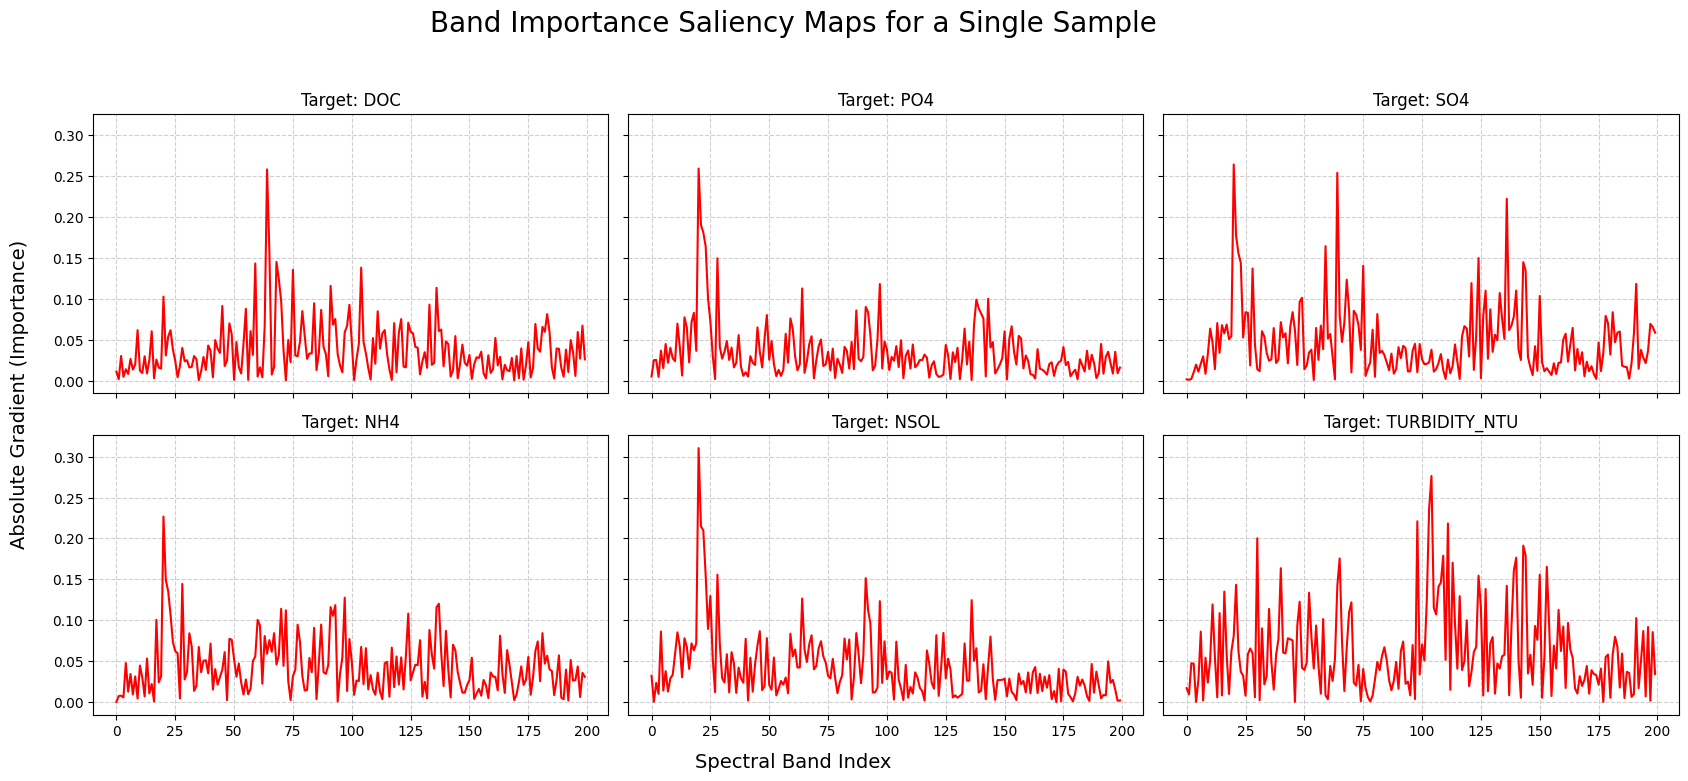

In [31]:
import matplotlib.pyplot as plt

def plot_saliency_grid(model, spectrum, target_cols, y_scaler, device):
    """
    Calculates and plots saliency maps for all target pollutants on a single 2x3 grid.
    """
    model.eval()
    
    # --- Create the subplot grid ---
    # figsize is (width, height) in inches
    fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True)
    fig.suptitle('Band Importance Saliency Maps for a Single Sample', fontsize=20)
    
    # Flatten the 2x3 axes array into a 1D array for easy iteration
    axes_flat = axes.flatten()

    for i, target_name in enumerate(target_cols):
        # --- Saliency Calculation for one target ---
        # We need to re-create the tensor and enable gradients for each backward pass
        spectrum_tensor = torch.tensor(spectrum, dtype=torch.float32, device=device).unsqueeze(0)
        spectrum_tensor.requires_grad_()

        # Zero out any previous gradients
        if spectrum_tensor.grad is not None:
            spectrum_tensor.grad.zero_()

        pred_scaled = model(spectrum_tensor)
        specific_output = pred_scaled[0, i]
        
        # The backward pass populates the .grad attribute
        specific_output.backward()
        
        saliency = spectrum_tensor.grad.data.abs().squeeze(0).cpu().numpy()
        
        # --- Plotting on the specific subplot ---
        ax = axes_flat[i]
        ax.plot(saliency, color='red', linewidth=1.5)
        ax.set_title(f"Target: {target_name.replace('lab_', '').replace('_mg_l', '').upper()}")
        ax.grid(True, linestyle='--', alpha=0.6)

    # --- Final figure adjustments ---
    # Add shared labels
    fig.text(0.5, 0.04, 'Spectral Band Index', ha='center', va='center', fontsize=14)
    fig.text(0.07, 0.5, 'Absolute Gradient (Importance)', ha='center', va='center', rotation='vertical', fontsize=14)
    
    # Clean up the layout to prevent titles/labels from overlapping
    plt.tight_layout(rect=[0.08, 0.05, 1, 0.95]) # Adjust rect to make space for shared labels/title
    plt.show()


# In your main block, after training:
print("\n--- Generating Saliency Maps for Model Interpretation ---")

# Pick a sample from the validation set to explain
# You can try different sample_idx values (0, 1, 2, ...) to see if the importances change
sample_idx = 0
spectrum_to_explain = X_val_scaled[sample_idx]

# Generate the 2x3 grid plot
plot_saliency_grid(trained_model, spectrum_to_explain, TARGET_COLS, y_scaler, DEVICE)